In [5]:
import os

HOME = os.getcwd()
print("HOME:", HOME)

HOME: /kaggle/working


In [4]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [6]:
import shutil

# shutil.rmtree("/kaggle/working/weights")
# shutil.rmtree("/kaggle/working/sam_models")
# shutil.rmtree("/kaggle/working/sam_baseline_img_dataset")
# shutil.rmtree("/kaggle/working/unet_models")

In [12]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
# !pip install supervision wget

## Data Loading, Visualisation and Image mask refinement using SAM

We are trying to load the Annotated Brain Tumour MRI image dataset that contains the annotations in the form of bounding box around the area where the tumour is possibly present. To improve the location visualisation of the tumour region in the brain MRI we are making use of SAM-1 model to refine the results and storing the segmented image and the masks for training the U-Net + SAM model architecture.

Using device: cuda
BRAIN TUMOR SEGMENTATION PIPELINE
With Supervision Package Integration

[1/5] Initializing data loader...

[2/5] Loading dataset...

Loading train set...
  Loading annotations from: /kaggle/input/labeled-brain-mri-dataset/train/_annotations.coco.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
  Found 1695 images in train directory


Processing train images: 100%|██████████| 1695/1695 [00:00<00:00, 11021.80it/s]



  train set class distribution:
The class ids in the dataset are: {0, 1, 2, 3}
    Glioma              :  565 images (564 with bboxes)
    Meningioma          :  358 images (358 with bboxes)
    No Tumour           :  335 images (335 with bboxes)
    Pituitary           :  437 images (437 with bboxes)

Loading valid set...
  Loading annotations from: /kaggle/input/labeled-brain-mri-dataset/valid/_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
  Found 502 images in valid directory


Processing valid images: 100%|██████████| 502/502 [00:00<00:00, 30235.51it/s]



  valid set class distribution:
The class ids in the dataset are: {0, 1, 2, 3}
    Glioma              :  161 images (160 with bboxes)
    Meningioma          :  124 images (124 with bboxes)
    No Tumour           :   99 images (99 with bboxes)
    Pituitary           :  118 images (118 with bboxes)

Loading test set...
  Loading annotations from: /kaggle/input/labeled-brain-mri-dataset/test/_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
  Found 246 images in test directory


Processing test images: 100%|██████████| 246/246 [00:00<00:00, 52777.43it/s]



  test set class distribution:
The class ids in the dataset are: {0, 1, 2, 3}
    Glioma              :   80 images (79 with bboxes)
    Meningioma          :   63 images (63 with bboxes)
    No Tumour           :   49 images (49 with bboxes)
    Pituitary           :   54 images (54 with bboxes)

[3/5] Computing dataset statistics...

DATASET STATISTICS

train Set:
----------------------------------------
  Glioma              :  565 ( 33.3%)
  Meningioma          :  358 ( 21.1%)
  No Tumour           :  335 ( 19.8%)
  Pituitary           :  437 ( 25.8%)
  Total               : 1695

valid Set:
----------------------------------------
  Glioma              :  161 ( 32.1%)
  Meningioma          :  124 ( 24.7%)
  No Tumour           :   99 ( 19.7%)
  Pituitary           :  118 ( 23.5%)
  Total               :  502

test Set:
----------------------------------------
  Glioma              :   80 ( 32.5%)
  Meningioma          :   63 ( 25.6%)
  No Tumour           :   49 ( 19.9%)
  Pituit

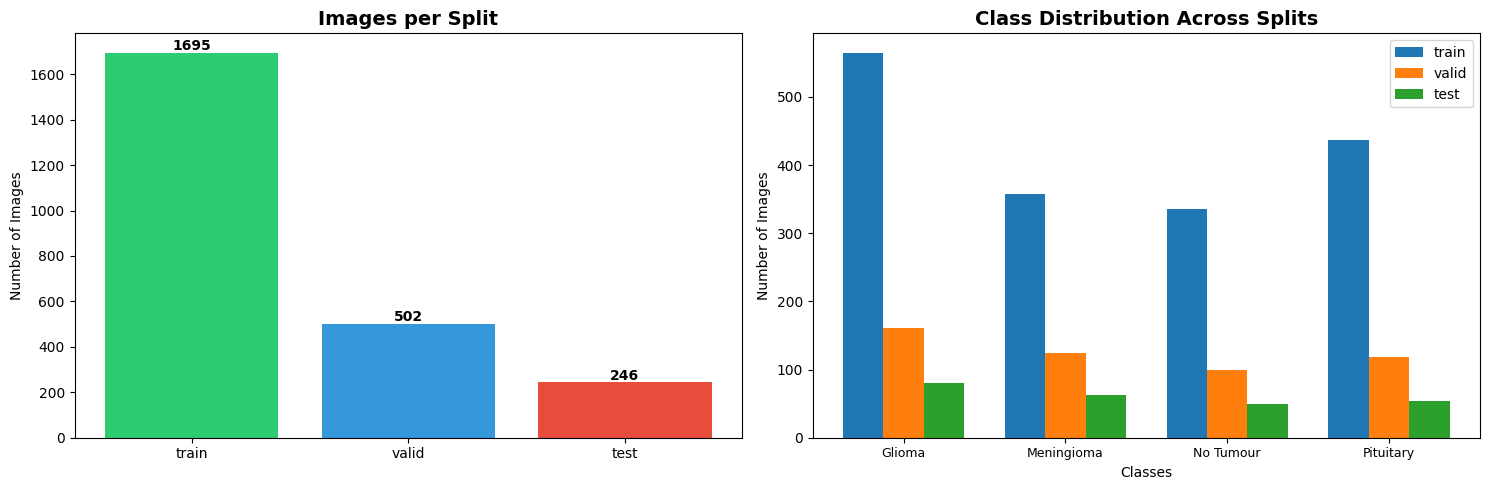


[4/5] Setting up SAM model...
Loading SAM model...from checkpoint path at /kaggle/working/weights/sam_vit_h_4b8939.pth
SAM model loaded successfully!

[5/5] Creating visualizations...

→ Plotting dataset overview with bounding boxes...


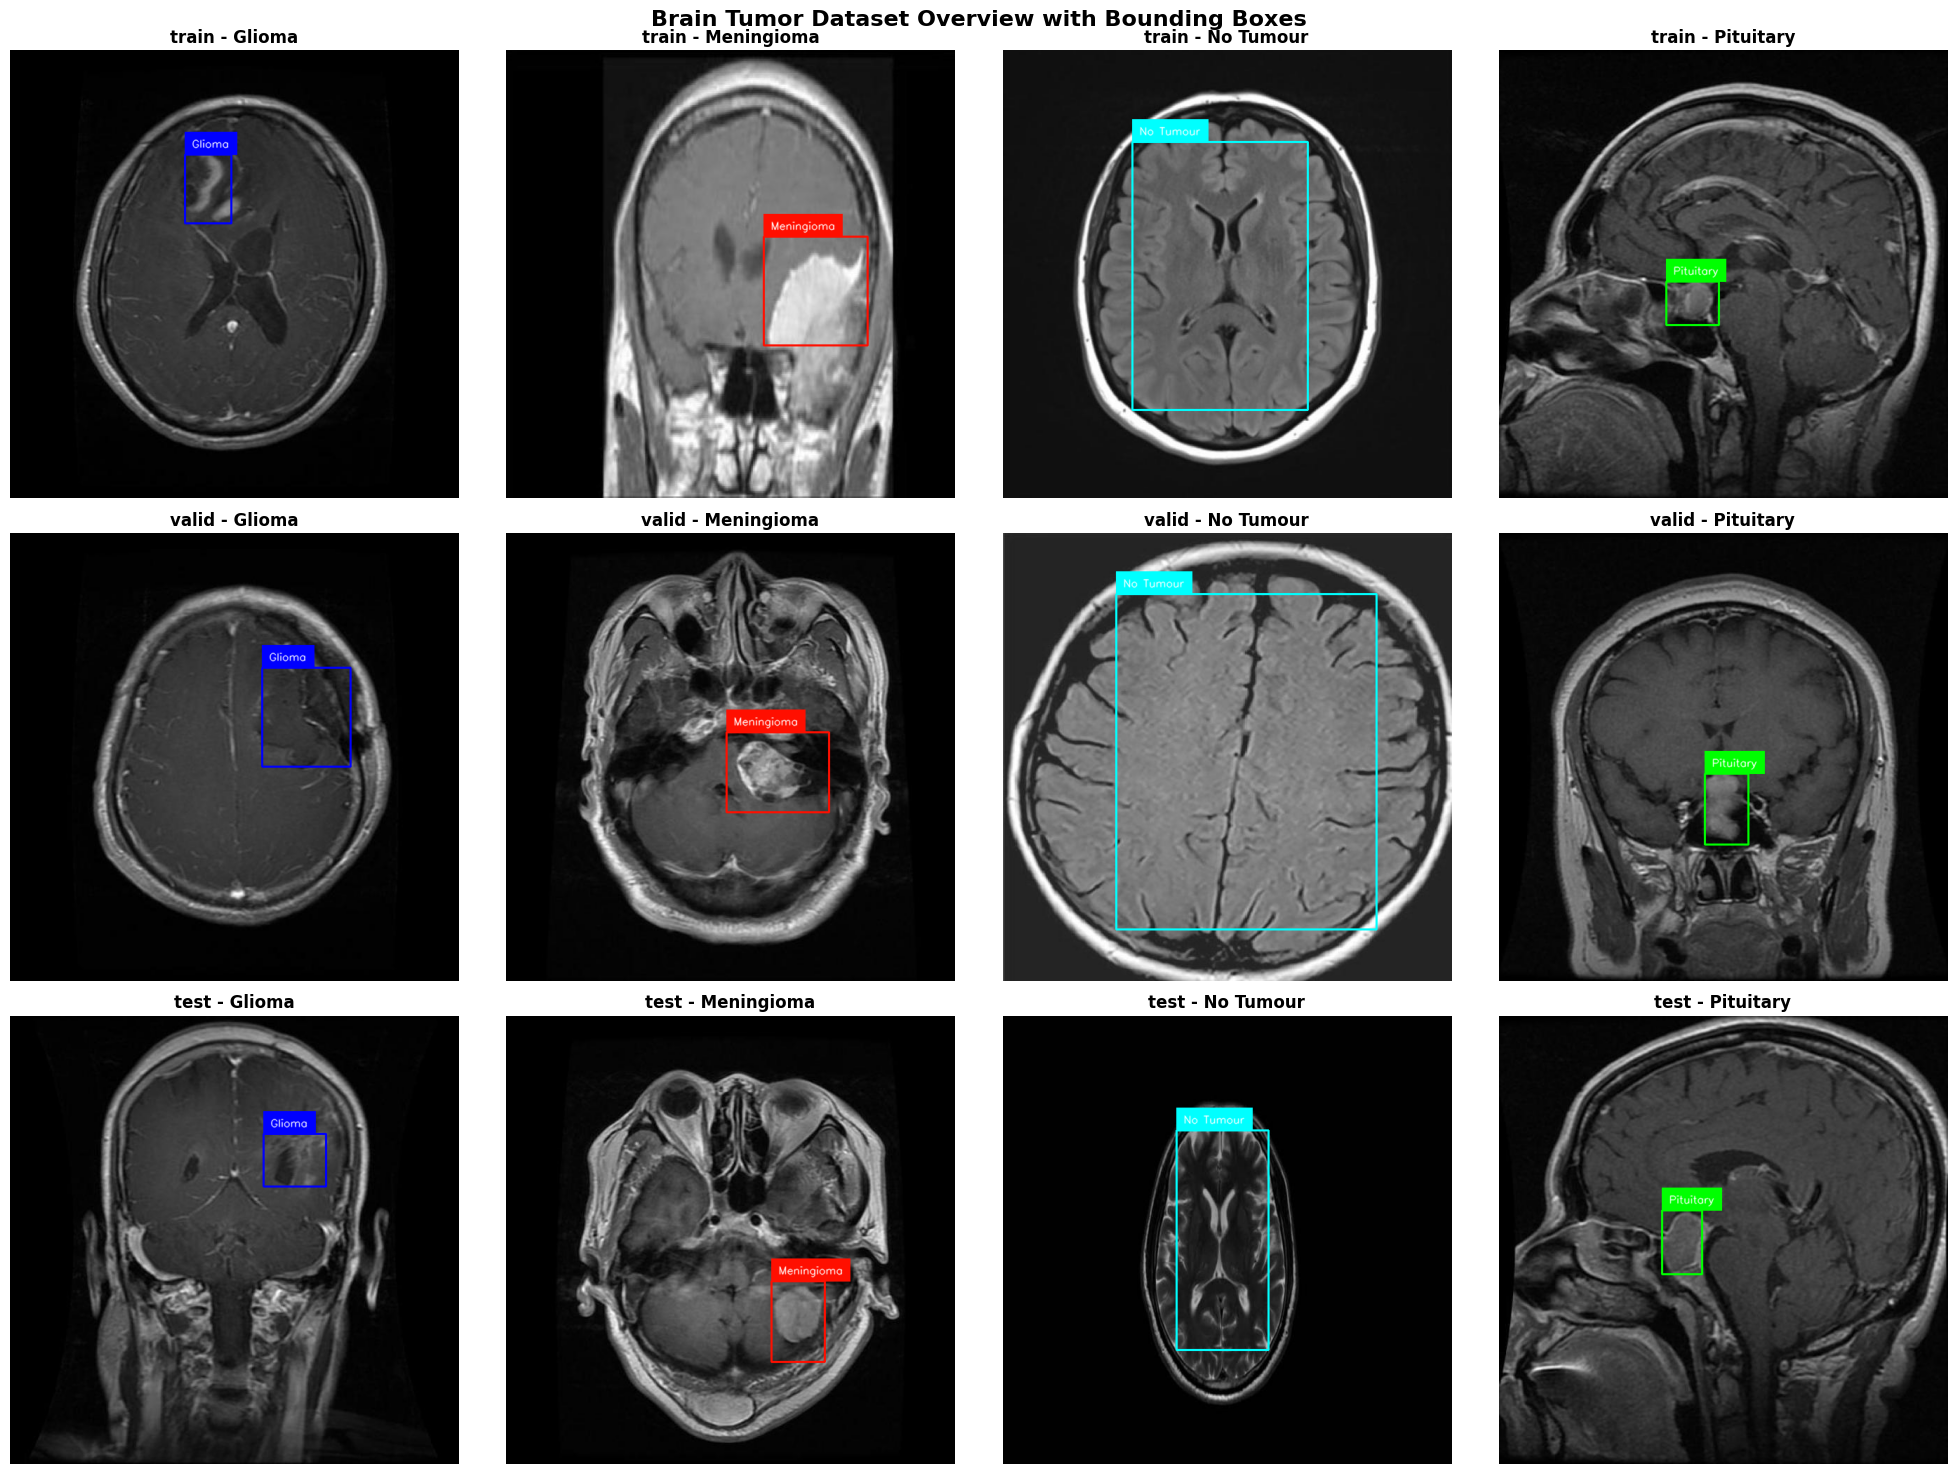


→ Plotting SAM refined segmentation masks...


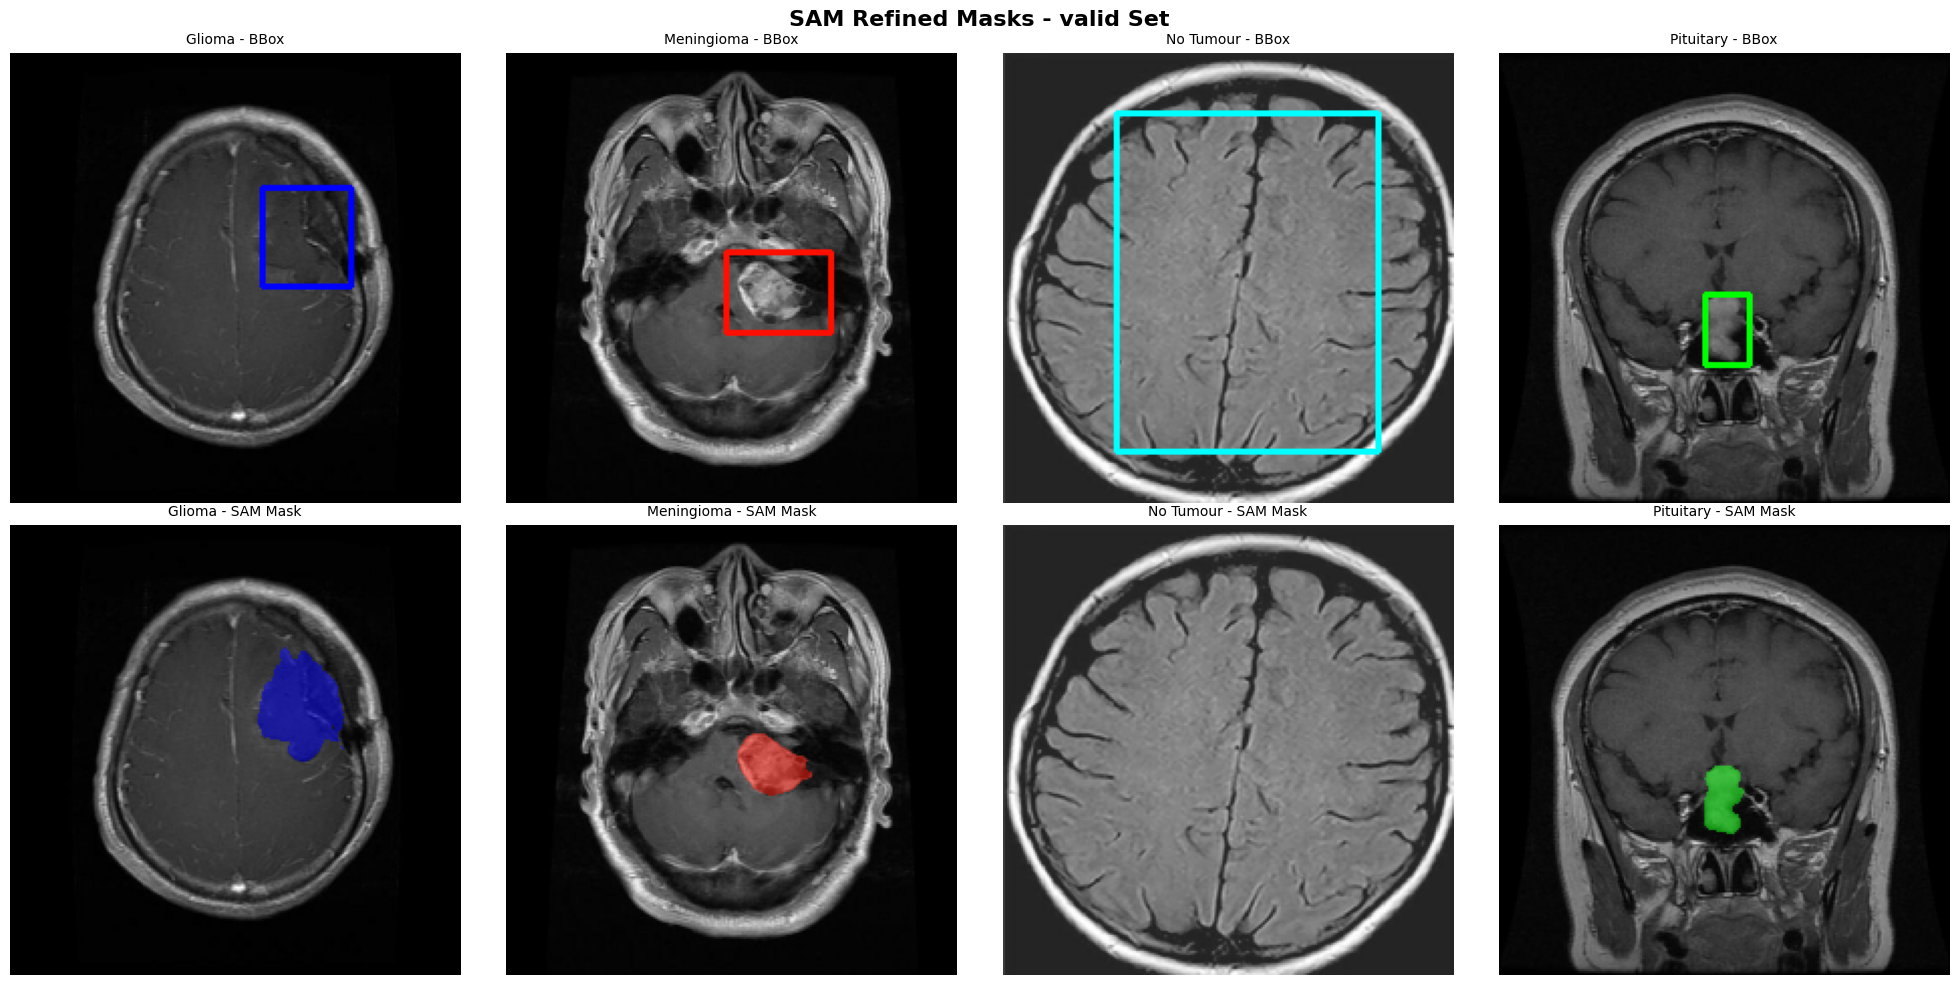

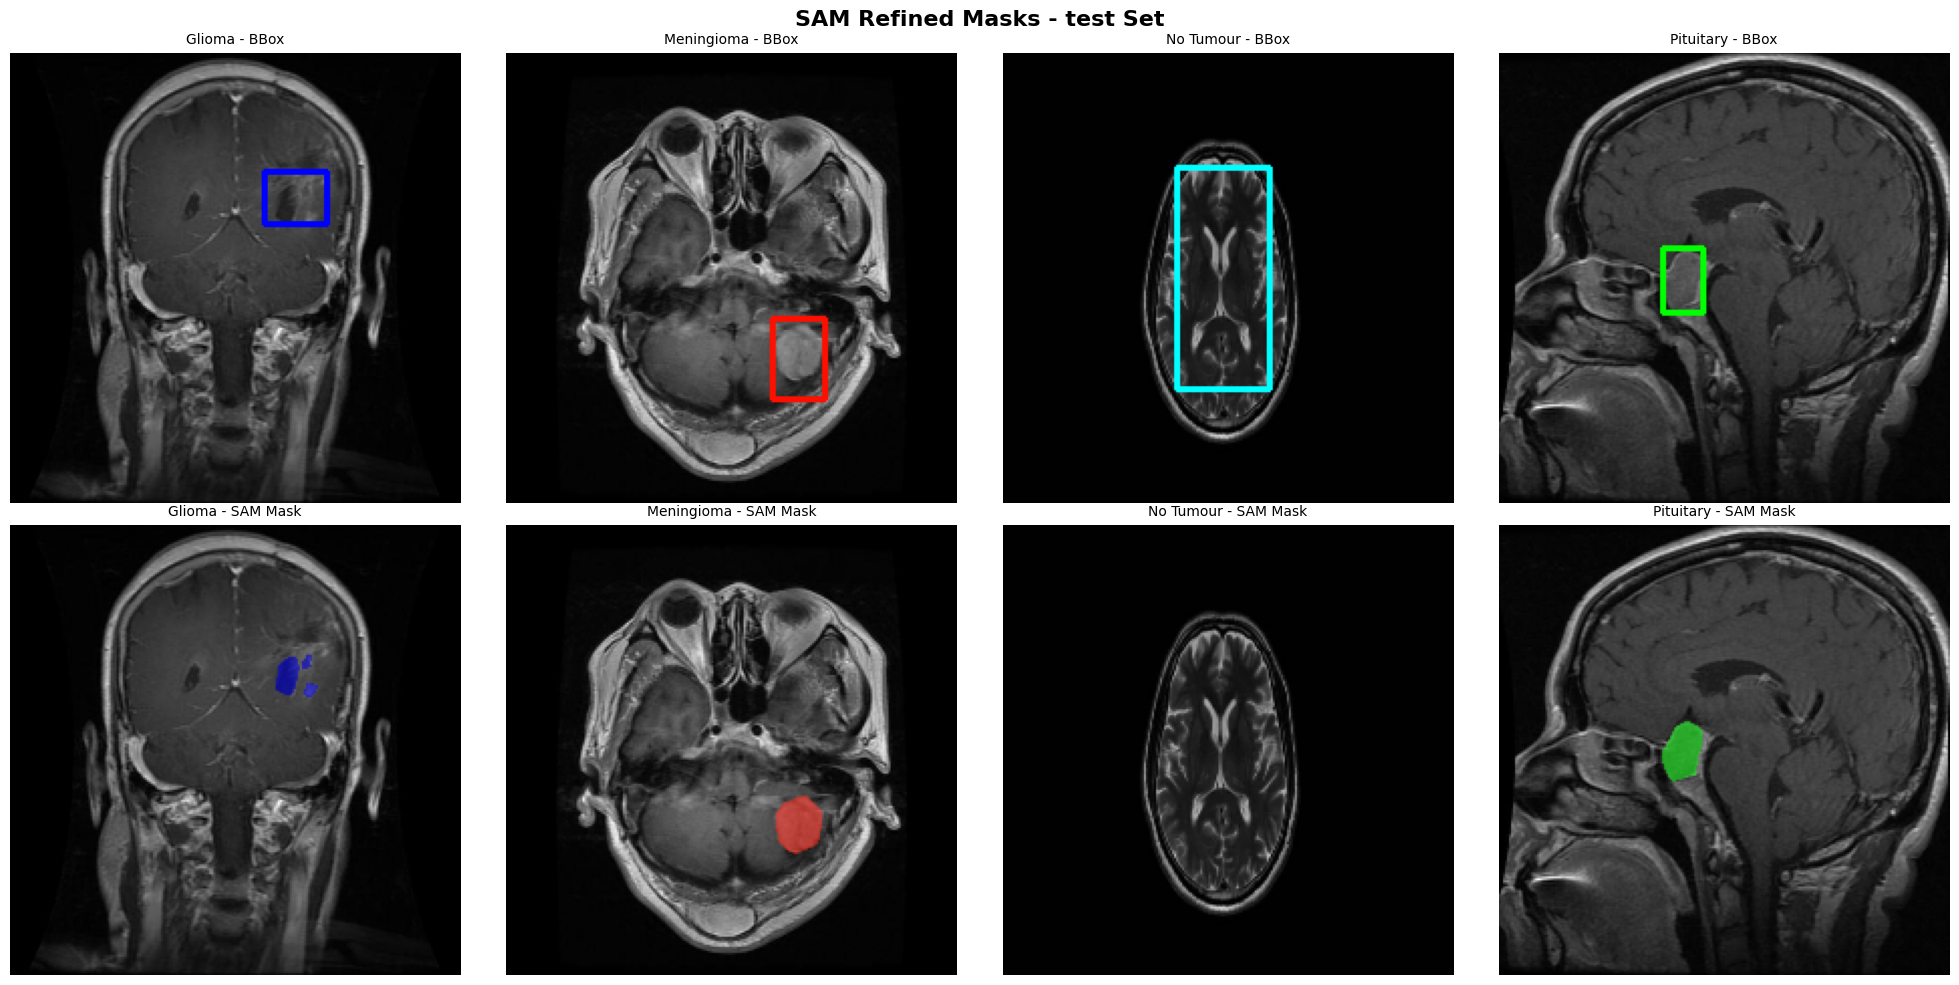


→ Generating SAM baselines...

Generating SAM baseline for train set...


Processing Pituitary: 100%|██████████| 437/437 [00:05<00:00, 77.94it/s]


✓ train baseline saved to: /kaggle/working/sam_baseline_img_test_dataset/train

Generating SAM baseline for valid set...


Processing Pituitary: 100%|██████████| 118/118 [00:01<00:00, 85.78it/s]


✓ valid baseline saved to: /kaggle/working/sam_baseline_img_test_dataset/valid

Generating SAM baseline for test set...


Processing Pituitary: 100%|██████████| 54/54 [00:00<00:00, 169.98it/s]


✓ test baseline saved to: /kaggle/working/sam_baseline_img_test_dataset/test

✓ PIPELINE EXECUTION COMPLETED SUCCESSFULLY!

Summary:
  • Total images processed: 2443
  • SAM baselines saved to: /kaggle/working/sam_baseline_img_dataset/
  • Device used: cuda


In [17]:
# Data Loading, Visualisation and Image mask refinement using SAM

# Enhanced Brain Tumor Segmentation Pipeline with Supervision Package

import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Install required packages
# !pip install -q segment-anything supervision transformers

# Import supervision for enhanced visualization
import supervision as sv
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import wget
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import random

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Constants
RESNET_INPUT_SIZE = 224  # ResNet-101 standard input size
SAM_INPUT_SIZE = 1024    # SAM model input size

# Define class names and colors for visualization
CLASS_NAMES = {
    0: 'Glioma',
    1: 'Meningioma',
    2: 'No Tumour',
    3: 'Pituitary'
}

# Define distinct colors for supervision package (RGB format)
CLASS_COLORS_RGB = {
    0: (0, 255, 0),      # No Tumor - Green
    1: (255, 0, 0),      # Glioma - Red
    2: (0, 0, 255),      # Meningioma - Blue
    3: (255, 255, 0)     # Pituitary - Yellow
}

# Create color palette for supervision
COLOR_PALETTE = sv.ColorPalette.from_hex([
    '#00FF00',  # Green - No Tumor
    '#FF0000',  # Red - Glioma
    '#000FFF',  # Blue - Meningioma
    '#FFFF00'   # Yellow - Pituitary
])

class BrainTumorDataLoader:
    """
    Enhanced data loader that sorts images by class from COCO annotations
    """
    
    def __init__(self, root_dir: str):
        self.root_dir = root_dir
        self.splits = ['train', 'valid', 'test'] # To be used initially to create SAM refined tumour segmentation.
        # self.splits = ['test'] # only load test dataset images with annotations once the SAM refinement is done.
        self.data = {}
        
        # Initialize supervision annotators
        self.box_annotator = sv.BoxAnnotator(
            thickness=2,
            color=COLOR_PALETTE
        )
        
        self.mask_annotator = sv.MaskAnnotator(
            color=COLOR_PALETTE,
            opacity=0.5
        )
        
        self.label_annotator = sv.LabelAnnotator(
            text_thickness=1,
            text_scale=0.5,
            color=COLOR_PALETTE
        )
    
    def load_coco_annotations(self, annotation_path: str):
        """Load COCO format annotations"""
        try:
            if os.path.exists(annotation_path):
                coco = COCO(annotation_path)
                return coco
        except:
            pass
        
        # Try manual loading if COCO tools fail
        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                return json.load(f)
        return None
    
    def get_image_class_from_annotations(self, coco_data, image_name: str) -> int:
        """
        Extract class ID for an image from COCO annotations.
        Returns 0 (No_Tumor) if no annotations found.
        """
        if coco_data is None:
            return 0
        
        if isinstance(coco_data, COCO):
            # Find image in COCO dataset
            img_id = None
            for img_info in coco_data.imgs.values():
                if img_info['file_name'] == image_name:
                    img_id = img_info['id']
                    break
            
            if img_id:
                # Get annotations for this image
                ann_ids = coco_data.getAnnIds(imgIds=img_id)
                anns = coco_data.loadAnns(ann_ids)
                
                if anns:
                    # Return the category_id of the first annotation
                    # Assuming one tumor per image
                    return anns[0].get('category_id', 0)
            
            return 0  # No tumor if no annotations
            
        else:  # Manual parsing for dict format
            # Find image in annotations
            img_info = None
            for img in coco_data.get('images', []):
                if img['file_name'] == image_name:
                    img_info = img
                    break
            
            if img_info:
                # Get annotations for this image
                for ann in coco_data.get('annotations', []):
                    if ann['image_id'] == img_info['id']:
                        return ann.get('category_id', 0)
            
            return 0  # No tumor if no annotations
    
    def get_bboxes_for_image(self, coco_data, image_name: str) -> list:
        """Get all bounding boxes for an image"""
        bboxes = []
        
        if coco_data is None:
            return bboxes
        
        if isinstance(coco_data, COCO):
            # Find image in COCO dataset
            img_id = None
            for img_info in coco_data.imgs.values():
                if img_info['file_name'] == image_name:
                    img_id = img_info['id']
                    break
            
            if img_id:
                ann_ids = coco_data.getAnnIds(imgIds=img_id)
                anns = coco_data.loadAnns(ann_ids)
                for ann in anns:
                    bboxes.append(ann['bbox'])
                    
        else:  # Manual parsing
            img_info = None
            for img in coco_data.get('images', []):
                if img['file_name'] == image_name:
                    img_info = img
                    break
            
            if img_info:
                for ann in coco_data.get('annotations', []):
                    if ann['image_id'] == img_info['id']:
                        bboxes.append(ann['bbox'])
        
        return bboxes
    
    def load_dataset(self) -> Dict:
        """
        Load the dataset and organize images by class based on COCO annotations
        """
        for split in self.splits:
            print(f"\nLoading {split} set...")
            split_path = os.path.join(self.root_dir, split)
            
            if not os.path.exists(split_path):
                print(f"Warning: {split} directory not found at {split_path}")
                continue
            
            # Load annotations file
            ann_path = os.path.join(split_path, '_annotations.coco.json')
            
            if os.path.exists(ann_path):
                print(f"  Loading annotations from: {ann_path}")
                coco = self.load_coco_annotations(ann_path)
            else:
                coco = None
            
            # Get all image files in the split directory
            image_files = [f for f in os.listdir(split_path) 
                          if f.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp'))]
            
            print(f"  Found {len(image_files)} images in {split} directory")
            
            # Initialize storage for sorted images
            split_data = {
                class_name: {
                    'path': split_path,
                    'images': [],
                    'annotations': coco,
                    'class_id': class_id,
                    'bboxes': {}  # Store bboxes per image
                }
                for class_id, class_name in CLASS_NAMES.items()
            }
            
            # Sort images by class based on annotations
            no_annotation_count = 0

            class_ids = set()
            for img_name in tqdm(image_files, desc=f"Processing {split} images"):
                # Get class ID from annotations
                class_id = self.get_image_class_from_annotations(coco, img_name)
                
                # Handle mapping between annotation category_id and our class_id
                # This might need adjustment based on your COCO annotation format
                # If category_ids in COCO are 1-indexed, adjust here:
                if class_id > 0 and class_id <= len(CLASS_NAMES):
                    class_id = class_id - 1  # Convert to 0-indexed if needed
                elif class_id == 0:
                    class_id = 0  # No tumor
                else:
                    # If class_id doesn't match expected range, default to No_Tumor
                    no_annotation_count += 1
                    class_id = 0
                class_ids.add(class_id);
                # Get class name
                class_name = CLASS_NAMES.get(class_id, CLASS_NAMES[1])
                
                # Add image to appropriate class
                split_data[class_name]['images'].append(img_name)
                
                # Store bounding boxes for this image
                bboxes = self.get_bboxes_for_image(coco, img_name)
                if bboxes:
                    split_data[class_name]['bboxes'][img_name] = bboxes
            
            # Print summary for this split
            print(f"\n  {split} set class distribution:")
            print(f"The class ids in the dataset are: {str(class_ids)}");
            for class_name in CLASS_NAMES.values():
                n_images = len(split_data[class_name]['images'])
                n_with_bbox = len(split_data[class_name]['bboxes'])
                print(f"    {class_name:20s}: {n_images:4d} images ({n_with_bbox} with bboxes)")
            
            if no_annotation_count > 0:
                print(f"  Note: {no_annotation_count} images had no valid annotations (assigned to No_Tumor)")
            
            self.data[split] = split_data
        
        return self.data
    
    def get_detections_from_coco(self, coco_data, image_path: str, image_shape: tuple) -> sv.Detections:
        """Convert COCO annotations to supervision Detections"""
        img_name = os.path.basename(image_path)
        
        # Initialize empty lists
        xyxy_boxes = []
        class_ids = []
        confidences = []
        
        if isinstance(coco_data, COCO):
            # Find image in COCO dataset
            img_id = None
            for img_info in coco_data.imgs.values():
                if img_info['file_name'] == img_name:
                    img_id = img_info['id']
                    break
            
            if img_id:
                ann_ids = coco_data.getAnnIds(imgIds=img_id)
                anns = coco_data.loadAnns(ann_ids)
                
                for ann in anns:
                    x, y, w, h = ann['bbox']
                    xyxy_boxes.append([x, y, x + w, y + h])
                    
                    # Map category_id to our class system
                    cat_id = ann.get('category_id', 1)
                    if cat_id > 0 and cat_id <= len(CLASS_NAMES):
                        class_ids.append(cat_id)  # Adjust if 1-indexed
                    else:
                        class_ids.append(0)
                    
                    confidences.append(ann.get('score', 1.0))
        
        elif isinstance(coco_data, dict):
            # Manual parsing for dict format
            img_info = None
            for img in coco_data.get('images', []):
                if img['file_name'] == img_name:
                    img_info = img
                    break
            
            if img_info:
                for ann in coco_data.get('annotations', []):
                    if ann['image_id'] == img_info['id']:
                        x, y, w, h = ann['bbox']
                        xyxy_boxes.append([x, y, x + w, y + h])
                        
                        # Map category_id to our class system
                        cat_id = ann.get('category_id', 1)
                        if cat_id > 0 and cat_id <= len(CLASS_NAMES):
                            class_ids.append(cat_id - 1)  # Adjust if 1-indexed
                        else:
                            class_ids.append(0)
                        
                        confidences.append(ann.get('score', 1.0))
        
        # Create supervision Detections object
        if xyxy_boxes:
            detections = sv.Detections(
                xyxy=np.array(xyxy_boxes),
                class_id=np.array(class_ids),
                confidence=np.array(confidences)
            )
        else:
            # Return empty detections
            detections = sv.Detections.empty()
        
        return detections
    
    def verify_dataset_loading(self):
        """Verify that the dataset was loaded correctly"""
        print("\n" + "="*60)
        print("DATASET LOADING VERIFICATION")
        print("="*60)
        
        if not self.data:
            print("ERROR: No data loaded!")
            return False
        
        all_good = True
        
        for split in self.splits:
            if split not in self.data:
                print(f"WARNING: {split} split not found in loaded data")
                all_good = False
                continue
            
            print(f"\n{split} Split Verification:")
            print("-" * 40)
            
            total_images = 0
            total_with_annotations = 0
            
            for class_name in CLASS_NAMES.values():
                if class_name not in self.data[split]:
                    print(f"  ERROR: Class '{class_name}' not found in {split} split")
                    all_good = False
                    continue
                
                class_data = self.data[split][class_name]
                n_images = len(class_data['images'])
                n_with_bbox = len(class_data.get('bboxes', {}))
                total_images += n_images
                total_with_annotations += n_with_bbox
                
                status = "✓" if n_images > 0 else "✗"
                print(f"  {status} {class_name:20s}: {n_images:4d} images, {n_with_bbox:4d} with annotations")
                
                # Show sample image names for verification
                if n_images > 0:
                    sample_imgs = class_data['images'][:3]
                    print(f"      Sample images: {', '.join(sample_imgs)}")
            
            print(f"\n  Total {split}: {total_images} images, {total_with_annotations} with annotations")
            
            if total_images == 0:
                print(f"  ERROR: No images found in {split} split!")
                all_good = False
        
        print("\n" + "="*60)
        if all_good:
            print("✓ Dataset loaded successfully!")
        else:
            print("✗ Dataset loading encountered issues. Please check the warnings above.")
        print("="*60)
        
        return all_good
    
    def save_organized_dataset(self, output_dir: str = '/kaggle/working/organized_dataset'):
        """
        Optionally save the organized dataset to disk for faster loading later
        """
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        print(f"\nSaving organized dataset to: {output_path}")
        
        # Save the organized structure as JSON
        organized_data = {}
        
        for split, split_data in self.data.items():
            organized_data[split] = {}
            for class_name, class_info in split_data.items():
                organized_data[split][class_name] = {
                    'images': class_info['images'],
                    'class_id': class_info['class_id'],
                    'n_images': len(class_info['images']),
                    'n_with_bboxes': len(class_info.get('bboxes', {}))
                }
        
        # Save as JSON
        json_path = output_path / 'organized_dataset.json'
        with open(json_path, 'w') as f:
            json.dump(organized_data, f, indent=2)
        
        print(f"✓ Dataset organization saved to: {json_path}")
        
        # Also save a summary report
        report_path = output_path / 'dataset_report.txt'
        with open(report_path, 'w') as f:
            f.write("BRAIN TUMOR DATASET ORGANIZATION REPORT\n")
            f.write("="*60 + "\n\n")
            
            for split, split_data in organized_data.items():
                f.write(f"{split} Split:\n")
                f.write("-"*40 + "\n")
                
                total = 0
                for class_name, info in split_data.items():
                    f.write(f"  {class_name:20s}: {info['n_images']:4d} images "
                           f"({info['n_with_bboxes']} with bboxes)\n")
                    total += info['n_images']
                
                f.write(f"  {'TOTAL':20s}: {total:4d} images\n\n")
        
        print(f"✓ Dataset report saved to: {report_path}")

class SAMSegmentationPipeline:
    """
    SAM segmentation pipeline with supervision integration
    """
    
    def __init__(self):
        self.model = None
        self.predictor = None
        self.mask_generator = None
        self.setup_sam()
    
    def setup_sam(self):
        """Download and setup SAM model"""
        # Create model directory
        model_dir = Path('/kaggle/working/weights')
        model_dir.mkdir(exist_ok=True)
        
        # Download SAM checkpoint if not exists
        checkpoint_path = model_dir / 'sam_vit_h_4b8939.pth'
        if not checkpoint_path.exists():
            print("Downloading SAM model checkpoint...")
            url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
            try:
                wget.download(url, str(checkpoint_path))
                print("\nDownload complete!")
            except:
                print("Please download the model manually from:", url)
        
        # Load SAM model
        print(f"Loading SAM model...from checkpoint path at {checkpoint_path}")
        sam = sam_model_registry["vit_h"](checkpoint=str(checkpoint_path)).to(device=device)
        
        self.model = sam
        self.predictor = SamPredictor(sam)
        self.mask_generator = SamAutomaticMaskGenerator(sam)
        print("SAM model loaded successfully!")
    
    def generate_masks_from_boxes(self, image: np.ndarray, boxes: np.ndarray) -> np.ndarray:
        """Generate segmentation masks from bounding boxes using SAM"""
        self.predictor.set_image(image)

        masks = []
        for box in boxes:
            mask, score, _ = self.predictor.predict(
                point_coords=None,
                point_labels=None,
                box=box[None, :],
                multimask_output=False,
            )
            masks.append(mask[0])
        
        if masks:
            return np.array(masks)
        return np.array([])
    
    def refine_detections_with_sam(self, image: np.ndarray, detections: sv.Detections) -> sv.Detections:
        """Refine detection boxes with SAM masks"""
        if len(detections) == 0:
            return detections
        
        # Generate masks from boxes
        masks = self.generate_masks_from_boxes(image, detections.xyxy)
        
        # Add masks to detections
        detections.mask = masks
        
        return detections

class EnhancedVisualizer:
    """
    Enhanced visualization using supervision package
    """
    
    def __init__(self, sam_pipeline: SAMSegmentationPipeline, data_loader: BrainTumorDataLoader):
        self.sam = sam_pipeline
        self.data_loader = data_loader
        
    def annotate_image(self, 
                      image: np.ndarray, 
                      detections: sv.Detections,
                      labels: List[str] = None,
                      with_mask: bool = True,
                      with_box: bool = True) -> np.ndarray:
        """Annotate image with boxes and masks using supervision"""
        annotated_image = image.copy()
        
        # Apply mask annotation if masks exist
        if with_mask and hasattr(detections, 'mask') and detections.mask is not None:
            annotated_image = self.data_loader.mask_annotator.annotate(
                scene=annotated_image,
                detections=detections
            )
        
        # Apply box annotation
        if with_box and len(detections) > 0:
            annotated_image = self.data_loader.box_annotator.annotate(
                scene=annotated_image,
                detections=detections,
            )
        
        # Add labels
        if labels and len(detections) > 0:
            annotated_image = self.data_loader.label_annotator.annotate(
                scene=annotated_image,
                detections=detections,
                labels=labels
            )
        
        return annotated_image
    
    def plot_dataset_overview(self, dataset: Dict):
        """Plot one image from each class for each split with annotations"""
        n_splits = len([s for s in self.data_loader.splits if s in dataset])
        
        fig, axes = plt.subplots(n_splits, 4, figsize=(20, 5 * n_splits))
        if n_splits == 1:
            axes = axes.reshape(1, -1)
        
        for split_idx, split in enumerate(self.data_loader.splits):
            if split not in dataset:
                continue
            
            for class_idx, class_name in enumerate(CLASS_NAMES.values()):
                if class_name not in dataset[split]:
                    continue
                
                class_info = dataset[split][class_name]
                if not class_info['images']:
                    continue
                
                # Get sample image
                img_name = class_info['images'][0]
                img_path = os.path.join(class_info['path'], img_name)
                
                # Load image
                image = cv2.imread(img_path)
                if image is None:
                    continue
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Get detections from COCO annotations
                detections = self.data_loader.get_detections_from_coco(
                    class_info['annotations'],
                    img_path,
                    image.shape
                )
                
                # Create labels
                labels = [class_name for _ in range(len(detections))]
                
                # Annotate image
                annotated = self.annotate_image(
                    image, 
                    detections, 
                    labels,
                    with_mask=False,
                    with_box=True
                )
                
                # Plot
                ax = axes[split_idx, class_idx]
                ax.imshow(annotated)
                ax.set_title(f'{split} - {class_name}', fontsize=12, fontweight='bold')
                ax.axis('off')

        # print(f"original detections: {detections}\n"); # debug
        plt.suptitle('Brain Tumor Dataset Overview with Bounding Boxes', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def plot_sam_refined_masks(self, dataset: Dict):
        """Plot images with SAM-refined segmentation masks"""

        for split in ['valid', 'test']:
            if split not in dataset:
                continue
            
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            
            for class_idx, class_name in enumerate(CLASS_NAMES.values()):
                if class_name not in dataset[split]:
                    continue
                
                class_info = dataset[split][class_name]
                if not class_info['images']:
                    continue
                
                # Get sample image
                img_name = class_info['images'][0]
                img_path = os.path.join(class_info['path'], img_name)
                # print(f"Image Name: {img_name} and Image Path: {img_path}\n\n") #debug
                
                # Load and resize image for ResNet
                image = cv2.imread(img_path)
                if image is None:
                    continue
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_resized = cv2.resize(image, (RESNET_INPUT_SIZE, RESNET_INPUT_SIZE))
                
                # Get detections
                detections = self.data_loader.get_detections_from_coco(
                    class_info['annotations'],
                    img_path,
                    image.shape
                )

                # print(f"Before SAM detections: {detections}\n\n") # debug

                # Scale detections to resized image
                if len(detections) > 0:
                    scale_x = RESNET_INPUT_SIZE / image.shape[1]
                    scale_y = RESNET_INPUT_SIZE / image.shape[0]
                    detections.xyxy[0, [0, 2]] = (detections.xyxy[:, [0, 2]]*scale_x).astype(np.int64)
                    detections.xyxy[0, [1, 3]] = (detections.xyxy[:, [1, 3]]*scale_y).astype(np.int64)
                    
                # Plot original with bbox
                ax1 = axes[0, class_idx]
                annotated_bbox = self.annotate_image(
                    image_resized,
                    detections,
                    # labels,
                    with_mask=False,
                    with_box=True
                )
                ax1.imshow(annotated_bbox)
                ax1.set_title(f'{class_name} - BBox', fontsize=10)
                ax1.axis('off')
                
                # Refine with SAM
                if class_info['class_id'] != 2:  # Not a No_Tumor class
                    # print(f"Creating SAM segmentation for {img_path}")
                    detections = self.sam.refine_detections_with_sam(image_resized, detections)

                # print(f"SAM detections: {detections}\n\n") # debug
                # Create labels
                labels = [f"{class_name} (SAM)" for _ in range(len(detections))]
                
                # Plot with SAM mask
                ax2 = axes[1, class_idx]
                annotated_mask = self.annotate_image(
                    image_resized,
                    detections,
                    # labels,
                    with_mask=True,
                    with_box=False
                )
                ax2.imshow(annotated_mask)
                ax2.set_title(f'{class_name} - SAM Mask', fontsize=10)
                ax2.axis('off')
            
            plt.suptitle(f'SAM Refined Masks - {split} Set', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()

class SAMBaselineGenerator:
    """
    Generate and save SAM baseline masks with supervision
    """
    
    def __init__(self, sam_pipeline: SAMSegmentationPipeline, data_loader: BrainTumorDataLoader):
        self.sam = sam_pipeline
        self.data_loader = data_loader
        self.output_dir = Path('/kaggle/working/sam_baseline_img_test_dataset')
        
    def process_and_save_split(self, dataset: Dict, split: str):
        """Process and save SAM masks for a split"""
        if split not in dataset:
            return
        
        print(f"\nGenerating SAM baseline for {split} set...")
        split_output_dir = self.output_dir / split
        split_output_dir.mkdir(parents=True, exist_ok=True)
        
        # Create supervision dataset
        sv_dataset = sv.DetectionDataset(
            classes=list(CLASS_NAMES.values()),
            images=[],
            annotations=[]
        )
        
        for class_name in [cls for cls in CLASS_NAMES.values() if cls != 'No Tumour']:
            if class_name not in dataset[split]:
                continue
            
            class_info = dataset[split][class_name]
            class_output_dir = split_output_dir / class_name
            class_output_dir.mkdir(exist_ok=True)
            
            # Process images with progress bar
            for img_name in tqdm(class_info['images'], desc=f"Processing {class_name}"):
                img_path = os.path.join(class_info['path'], img_name)
                
                # Load image
                image = cv2.imread(img_path)
                if image is None:
                    continue
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Resize for ResNet
                image_resized = cv2.resize(image, (RESNET_INPUT_SIZE, RESNET_INPUT_SIZE))
                
                # Get detections
                detections = self.data_loader.get_detections_from_coco(
                    class_info['annotations'],
                    img_path,
                    image.shape
                )
                
                # Scale detections
                if len(detections) > 0:
                    scale_x = RESNET_INPUT_SIZE / image.shape[1]
                    scale_y = RESNET_INPUT_SIZE / image.shape[0]
                    detections.xyxy[0, [0, 2]] = (detections.xyxy[0, [0, 2]]*scale_x).astype(np.int64)
                    detections.xyxy[0, [1, 3]] = (detections.xyxy[0, [1, 3]]*scale_y).astype(np.int64)
                    
                    # Generate SAM masks
                    detections = self.sam.refine_detections_with_sam(image_resized, detections)
                    
                    # Save mask
                    if hasattr(detections, 'mask') and detections.mask is not None:
                        mask_path = class_output_dir / f'{Path(img_name).stem}_mask.npy'
                        np.save(mask_path, detections.mask)
                
                # Save annotated image
                labels = [class_name for _ in range(len(detections))]
                annotated = self.data_loader.mask_annotator.annotate(
                    scene=image_resized.copy(),
                    detections=detections
                ) if len(detections) > 0 else image_resized
                
                img_save_path = class_output_dir / f'{Path(img_name).stem}_annotated.jpg'
                # cv2.imwrite(str(img_save_path), cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))
                cv2.imwrite(str(img_save_path), cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR))
        
        print(f"✓ {split} baseline saved to: {split_output_dir}")

class DatasetStatistics:
    """
    Compute and display dataset statistics
    """
    
    @staticmethod
    def compute_statistics(dataset: Dict):
        """Compute comprehensive dataset statistics"""
        stats = {
            'total_images': 0,
            'splits': {},
            'class_distribution': {}
        }
        
        print("\n" + "="*60)
        print("DATASET STATISTICS")
        print("="*60)
        
        for split in dataset:
            split_stats = {
                'total': 0,
                'classes': {}
            }
            
            for class_name, class_info in dataset[split].items():
                n_images = len(class_info['images'])
                split_stats['classes'][class_name] = n_images
                split_stats['total'] += n_images
                
                if class_name not in stats['class_distribution']:
                    stats['class_distribution'][class_name] = {}
                stats['class_distribution'][class_name][split] = n_images
            
            stats['splits'][split] = split_stats
            stats['total_images'] += split_stats['total']
        
        # Display statistics
        for split, split_stats in stats['splits'].items():
            print(f"\n{split} Set:")
            print("-" * 40)
            for class_name, count in split_stats['classes'].items():
                percentage = (count / split_stats['total']) * 100
                print(f"  {class_name:20s}: {count:4d} ({percentage:5.1f}%)")
            print(f"  {'Total':20s}: {split_stats['total']:4d}")
        
        print("\n" + "="*60)
        print(f"TOTAL DATASET SIZE: {stats['total_images']} images")
        print("="*60)
        
        # Plot distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot 1: Images per split
        splits = list(stats['splits'].keys())
        split_totals = [stats['splits'][s]['total'] for s in splits]
        ax1.bar(splits, split_totals, color=['#2ecc71', '#3498db', '#e74c3c'])
        ax1.set_title('Images per Split', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Number of Images')
        for i, v in enumerate(split_totals):
            ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')
        
        # Plot 2: Class distribution across splits
        x = np.arange(len(CLASS_NAMES))
        width = 0.25
        
        for i, split in enumerate(splits):
            values = [stats['splits'][split]['classes'].get(class_name, 0) 
                     for class_name in CLASS_NAMES.values()]
            ax2.bar(x + i * width, values, width, label=split)
        
        ax2.set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Number of Images')
        ax2.set_xlabel('Classes')
        ax2.set_xticks(x + width)
        ax2.set_xticklabels([name.replace('_', '\n') for name in CLASS_NAMES.values()], 
                           rotation=0, fontsize=9)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        return stats

def main_pipeline():
    """
    Main execution pipeline with supervision integration
    """
    print("="*60)
    print("BRAIN TUMOR SEGMENTATION PIPELINE")
    print("With Supervision Package Integration")
    print("="*60)
    
    # Configuration
    root_dir = '/kaggle/input/labeled-brain-mri-dataset'  # Update this path
    
    try:
        # Step 1: Initialize data loader
        print("\n[1/5] Initializing data loader...")
        data_loader = BrainTumorDataLoader(root_dir)
        
        # Step 2: Load dataset
        print("\n[2/5] Loading dataset...")
        dataset = data_loader.load_dataset()
        
        # Step 3: Compute and display statistics
        print("\n[3/5] Computing dataset statistics...")
        stats = DatasetStatistics.compute_statistics(dataset)
        
        # Step 4: Initialize SAM
        print("\n[4/5] Setting up SAM model...")
        sam_pipeline = SAMSegmentationPipeline()
        
        # Step 5: Visualize with supervision
        print("\n[5/5] Creating visualizations...")
        visualizer = EnhancedVisualizer(sam_pipeline, data_loader)
        
        # Plot dataset overview with bounding boxes
        print("\n→ Plotting dataset overview with bounding boxes...")
        visualizer.plot_dataset_overview(dataset)
        
        # Plot SAM refined masks
        print("\n→ Plotting SAM refined segmentation masks...")
        visualizer.plot_sam_refined_masks(dataset)
        
        # # Generate baselines for Valid and Test sets
        # print("\n→ Generating SAM baselines...")
        # baseline_generator = SAMBaselineGenerator(sam_pipeline, data_loader)
        
        # for split in ['train', 'valid', 'test']:
        #     baseline_generator.process_and_save_split(dataset, split)
        
        print("\n" + "="*60)
        print("✓ PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
        print("="*60)
        
        # Summary
        print("\nSummary:")
        print(f"  • Total images processed: {stats['total_images']}")
        print(f"  • SAM baselines saved to: /kaggle/working/sam_baseline_img_dataset/")
        print(f"  • Device used: {device}")

        return data_loader
        
    except FileNotFoundError as e:
        print(f"\n❌ Error: Dataset not found!")
        print(f"   Please check the path: {root_dir}")
        print("\nExpected structure:")
        print("  root_dir/")
        print("    ├── Train/")
        print("    │   ├── No_Tumor/")
        print("    │   ├── Glioma_Tumor/")
        print("    │   ├── Meningioma_Tumor/")
        print("    │   └── Pituitary_Tumor/")
        print("    ├── Valid/")
        print("    └── Test/")
        
    except Exception as e:
        print(f"\n❌ An error occurred: {e}")
        import traceback
        traceback.print_exc()

# Execute the main pipeline
data_loader = None
if __name__ == "__main__":
    data_loader = main_pipeline()

In [ ]:
# import cv2
# import numpy as np
# import glob
# import os

# def load_image_mask_pairs(image_dir, mask_dir):
#     """
#     Loads matched image and mask pairs from specified directories.

#     Args:
#         image_dir (str): Path to the directory containing .jpg images.
#         mask_dir (str): Path to the directory containing .npy masks.

#     Returns:
#         tuple: (list of loaded images, list of loaded masks) as numpy arrays.
#     """
#     # 1. Get all image paths and sort them alphabetically
#     image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    
#     # 2. Get all mask paths and sort them alphabetically
#     mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.npy')))
    
#     # Crucial check: Ensure the lists are the same length
#     if len(image_paths) != len(mask_paths):
#         raise ValueError("Mismatch between number of images and masks in directories.")
        
#     # Optional check: Verify filenames match (excluding extensions)
#     for img_path, mask_path in zip(image_paths, mask_paths):
#         img_name = os.path.splitext(os.path.basename(img_path))[0]
#         mask_name = os.path.splitext(os.path.basename(mask_path))[0]
#         if img_name != mask_name:
#             print(f"Warning: Filenames mismatch for {img_name} and {mask_name}. Data might be misaligned.")
            
#     loaded_images = []
#     loaded_masks = []

#     for img_path, mask_path in zip(image_paths, mask_paths):
#         # Load the image using OpenCV
#         # OpenCV loads images in BGR format by default
#         image = cv2.imread(img_path)
        
#         # Convert the image from BGR to RGB format, as is standard in deep learning frameworks
#         image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         # Load the mask using NumPy
#         # Masks in .npy format are typically loaded as is (e.g., boolean or integer arrays)
#         mask = np.load(mask_path)
        
#         loaded_images.append(image_rgb)
#         loaded_masks.append(mask)

#     return loaded_images, loaded_masks

# # --- Example Usage ---
# image_folder = "/kaggle/working/sam_baseline_img_test_dataset/test/Meningioma" # Replace with your image directory path
# mask_folder = "/kaggle/working/sam_baseline_img_test_dataset/test/Meningioma"   # Replace with your mask directory path

# # Create a sample structure for demonstration purposes if running locally
# os.makedirs(image_folder, exist_ok=True)
# os.makedirs(mask_folder, exist_ok=True)
# # Add dummy files if needed to test

# try:
#     images, masks = load_image_mask_pairs(image_folder, mask_folder)
#     print(f"Successfully loaded {len(images)} image(s) and {len(masks)} mask(s).")
    
#     if images and masks:
#         print(f"First image shape: {images[0].shape}, dtype: {images[0].dtype}")
#         print(f"First mask shape: {masks[0].shape}, dtype: {masks[0].dtype}")

# except FileNotFoundError:
#     print(f"One or both directories not found: {image_folder} or {mask_folder}")
# except ValueError as e:
#     print(f"Error loading data: {e}")



## Experimenting to accurately load the data into the notebook environment

In [23]:
# # Fixed U-Net Training Pipeline with Correct Mask Handling
# # Handles masks with shape (1, 224, 224) and dtype bool

# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from pathlib import Path
# from tqdm.auto import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.cuda.amp import autocast, GradScaler

# import cv2
# from PIL import Image
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import random
# import json
# from datetime import datetime
# import gc

# # Memory optimization for T4 GPU
# torch.cuda.empty_cache()
# gc.collect()

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")
# if torch.cuda.is_available():
#     print(f"GPU: {torch.cuda.get_device_name()}")
#     print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# # Enable cudNN optimization
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True

# # ============================================================================
# # CONFIGURATION
# # ============================================================================

# class Config:
#     """Configuration class for training parameters"""
    
#     # Paths
#     DATA_ROOT = Path('/kaggle/working/sam_baseline_img_test_dataset')
#     RESNET_WEIGHTS = Path('/kaggle/input/resnet-101/pytorch/brain-tumour-ft/1/resnet101_brain_tumor_20251105_163019.pth')
#     OUTPUT_DIR = Path('/kaggle/working/unet_outputs')
    
#     # Data parameters
#     INPUT_SIZE = 224  # ResNet-101 standard input
#     TUMOR_CLASSES = ['Glioma', 'Meningioma', 'Pituitary']
    
#     # Training parameters - Optimized for T4 GPU
#     BATCH_SIZE = 16  # Optimal for T4 GPU with mixed precision
#     VAL_BATCH_SIZE = 32  # Can use larger batch for validation
#     NUM_WORKERS = 2  # Kaggle has 2 CPU cores
#     PIN_MEMORY = True
    
#     # Training schedule
#     FREEZE_EPOCHS = 5  # Epochs with frozen encoder
#     UNFREEZE_EPOCHS = 15  # Additional epochs with unfrozen encoder
#     TOTAL_EPOCHS = FREEZE_EPOCHS + UNFREEZE_EPOCHS
    
#     # Learning rates
#     LR_DECODER = 1e-3  # Learning rate for decoder (frozen encoder phase)
#     LR_FULL = 1e-4  # Learning rate for full model (unfrozen phase)
#     LR_MIN = 1e-6  # Minimum learning rate for scheduler
    
#     # Mixed precision training
#     USE_AMP = True  # Automatic Mixed Precision for T4 GPU
    
#     # Validation
#     VAL_FREQUENCY = 1  # Validate every N epochs
#     SAVE_BEST = True
    
#     def __init__(self):
#         self.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
#         self.CHECKPOINT_DIR = self.OUTPUT_DIR / 'checkpoints'
#         self.CHECKPOINT_DIR.mkdir(exist_ok=True)
#         self.VIS_DIR = self.OUTPUT_DIR / 'visualizations'
#         self.VIS_DIR.mkdir(exist_ok=True)

# config = Config()

# # ============================================================================
# # FIXED DATASET CLASS FOR (1, 224, 224) BOOLEAN MASKS
# # ============================================================================

# class BrainTumorSegmentationDataset(Dataset):
#     """
#     Fixed dataset class for masks with shape (1, 224, 224) and dtype bool
#     """
    
#     def __init__(self, 
#                  data_root: Path,
#                  split: str,
#                  transform=None,
#                  cache_data: bool = False,
#                  debug: bool = False):
#         """
#         Args:
#             data_root: Root directory containing train/valid/test splits
#             split: One of 'train', 'valid', 'test'
#             transform: Albumentations transform pipeline
#             cache_data: Whether to cache data in memory
#             debug: Print debug information
#         """
#         self.data_root = data_root
#         self.split = split
#         self.transform = transform
#         self.cache_data = cache_data
#         self.debug = debug
        
#         # Collect all image and mask paths
#         self.image_paths = []
#         self.mask_paths = []
#         self.classes = []
        
#         split_dir = data_root / split
        
#         print(f"\nLoading {split} dataset from: {split_dir}")
        
#         for tumor_class in config.TUMOR_CLASSES:
#             class_dir = split_dir / tumor_class
#             if not class_dir.exists():
#                 print(f"Warning: {class_dir} does not exist")
#                 continue
            
#             # Look for annotated images
#             images = sorted(list(class_dir.glob('*_annotated.jpg')))
#             if not images:
#                 # Try alternative pattern
#                 images = sorted(list(class_dir.glob('*.jpg')))
            
#             print(f"Found {len(images)} images in {tumor_class}")
            
#             for img_path in images:
#                 # Try different mask naming patterns
#                 mask_candidates = [
#                     class_dir / img_path.stem.replace('_annotated', '_mask.npy'),
#                     class_dir / (img_path.stem.replace('_annotated', '') + '_mask.npy'),
#                     class_dir / (img_path.stem + '.npy'),
#                 ]
                
#                 mask_path = None
#                 for candidate in mask_candidates:
#                     if candidate.exists():
#                         mask_path = candidate
#                         break
                
#                 if mask_path:
#                     self.image_paths.append(str(img_path))
#                     self.mask_paths.append(str(mask_path))
#                     self.classes.append(tumor_class)
#                 elif self.debug:
#                     print(f"Warning: No mask found for {img_path.name}")
        
#         if len(self.image_paths) == 0:
#             raise ValueError(f"No valid image-mask pairs found in {split_dir}")
        
#         print(f"\nLoaded {len(self.image_paths)} samples from {split} set")
#         class_dist = dict(zip(*np.unique(self.classes, return_counts=True)))
#         print(f"Class distribution: {class_dist}")
        
#         # Validate first sample if debug
#         if self.debug and len(self.image_paths) > 0:
#             self._validate_sample()
    
#     def _validate_sample(self):
#         """Validate the first sample to check data format"""
#         print("\nValidating sample data...")
#         img_path = self.image_paths[0]
#         mask_path = self.mask_paths[0]
        
#         # Load and check image
#         image = cv2.imread(img_path)
#         print(f"Image shape: {image.shape}, dtype: {image.dtype}")
        
#         # Load and check mask
#         mask = np.load(mask_path)
#         print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
#         print(f"Mask unique values: {np.unique(mask)}")
    
#     def __len__(self):
#         return len(self.image_paths)
    
#     def __getitem__(self, idx):
#         # Load image
#         image = cv2.imread(self.image_paths[idx])
#         if image is None:
#             raise ValueError(f"Failed to load image: {self.image_paths[idx]}")
        
#         # Convert BGR to RGB
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
#         # Load mask
#         mask = np.load(self.mask_paths[idx])
        
#         # Handle mask format: (1, 224, 224) bool -> (224, 224) float32
#         if mask.shape == (1, 224, 224):
#             mask = mask[0]  # Remove channel dimension to get (224, 224)
#         elif mask.shape == (224, 224, 1):
#             mask = mask[:, :, 0]  # Remove channel dimension
        
#         # Convert boolean to float
#         if mask.dtype == bool:
#             mask = mask.astype(np.float32)
#         else:
#             mask = mask.astype(np.float32)
#             # Ensure binary
#             if mask.max() > 1:
#                 mask = (mask > 0).astype(np.float32)
        
#         # Verify shapes - both should be (224, 224, 3) and (224, 224) at this point
#         assert image.shape == (224, 224, 3), f"Image shape should be (224, 224, 3), got {image.shape}"
#         assert mask.shape == (224, 224), f"Mask shape should be (224, 224), got {mask.shape}"
        
#         # Apply transforms
#         if self.transform:
#             augmented = self.transform(image=image, mask=mask)
#             image = augmented['image']  # This will be a tensor (3, 224, 224)
#             mask = augmented['mask']    # This will be a tensor (224, 224)
            
#             # Add channel dimension to mask after transform
#             if len(mask.shape) == 2:
#                 mask = mask.unsqueeze(0)  # Add channel dimension -> (1, 224, 224)
#         else:
#             # Manual conversion without transforms
#             image = image.astype(np.float32) / 255.0
#             image = torch.from_numpy(image).permute(2, 0, 1)  # (3, 224, 224)
#             mask = torch.from_numpy(mask).unsqueeze(0)  # (1, 224, 224)
        
#         # Final validation
#         assert image.shape == (3, 224, 224), f"Final image shape mismatch: {image.shape}"
#         assert mask.shape == (1, 224, 224), f"Final mask shape mismatch: {mask.shape}"
        
#         return image.float(), mask.float(), self.classes[idx]

# # ============================================================================
# # DATA AUGMENTATION - FIXED FOR PROPER MASK HANDLING
# # ============================================================================

# def get_transforms():
#     """Get data augmentation transforms that properly handle masks"""
    
#     train_transform = A.Compose([
#         # Ensure input is uint8 for albumentations
#         A.Lambda(image=lambda x, **kwargs: x.astype(np.uint8), 
#                 mask=lambda x, **kwargs: x.astype(np.float32)),
        
#         # Spatial transforms
#         A.RandomRotate90(p=0.5),
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.3),
#         A.ShiftScaleRotate(
#             shift_limit=0.1,
#             scale_limit=0.1,
#             rotate_limit=15,
#             border_mode=cv2.BORDER_CONSTANT,
#             value=0,
#             mask_value=0,
#             p=0.5
#         ),
        
#         # Elastic deformations
#         A.OneOf([
#             A.ElasticTransform(
#                 alpha=120, 
#                 sigma=120 * 0.05, 
#                 alpha_affine=120 * 0.03,
#                 border_mode=cv2.BORDER_CONSTANT,
#                 value=0,
#                 mask_value=0,
#                 p=1.0
#             ),
#             A.GridDistortion(
#                 border_mode=cv2.BORDER_CONSTANT,
#                 value=0,
#                 mask_value=0,
#                 p=1.0
#             ),
#         ], p=0.3),
        
#         # Only apply to image, not mask
#         A.OneOf([
#             A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
#             A.GaussianBlur(blur_limit=(3, 7), p=1.0),
#         ], p=0.3),
        
#         A.OneOf([
#             A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),
#         ], p=0.3),
        
#         # Normalize and convert to tensor
#         A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225]
#         ),
#         ToTensorV2()
#     ])
    
#     val_transform = A.Compose([
#         A.Lambda(image=lambda x, **kwargs: x.astype(np.uint8), 
#                 mask=lambda x, **kwargs: x.astype(np.float32)),
#         A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225]
#         ),
#         ToTensorV2()
#     ])
    
#     return train_transform, val_transform

# # ============================================================================
# # TEST DATA LOADING
# # ============================================================================

# def test_data_loading():
#     """Test data loading to ensure everything works correctly"""
#     print("\n" + "="*60)
#     print("TESTING DATA LOADING")
#     print("="*60)
    
#     # Get transforms
#     train_transform, val_transform = get_transforms()
    
#     # Test without transforms first
#     print("\nTesting without transforms...")
#     try:
#         dataset_no_transform = BrainTumorSegmentationDataset(
#             config.DATA_ROOT, 
#             'train', 
#             transform=None,
#             cache_data=False,
#             debug=True
#         )
        
#         image, mask, cls = dataset_no_transform[0]
#         print(f"✓ No transform: Image {image.shape}, Mask {mask.shape}, Class: {cls}")
#     except Exception as e:
#         print(f"✗ Error without transforms: {e}")
    
#     # Test with transforms
#     print("\nTesting with transforms...")
#     try:
#         dataset_with_transform = BrainTumorSegmentationDataset(
#             config.DATA_ROOT, 
#             'train', 
#             transform=val_transform,
#             cache_data=False,
#             debug=True
#         )
        
#         image, mask, cls = dataset_with_transform[0]
#         print(f"✓ With transform: Image {image.shape}, Mask {mask.shape}, Class: {cls}")
#     except Exception as e:
#         print(f"✗ Error with transforms: {e}")
#         import traceback
#         traceback.print_exc()
    
#     # Test DataLoader
#     print("\nTesting DataLoader...")
#     try:
#         dataset = BrainTumorSegmentationDataset(
#             config.DATA_ROOT, 
#             'train', 
#             transform=val_transform,
#             cache_data=False,
#             debug=False
#         )
        
#         dataloader = DataLoader(
#             dataset,
#             batch_size=4,
#             shuffle=False,
#             num_workers=0,  # Use 0 for debugging
#             pin_memory=False
#         )
        
#         # Get one batch
#         images, masks, classes = next(iter(dataloader))
#         print(f"✓ Batch loaded: Images {images.shape}, Masks {masks.shape}")
#         print(f"  Batch classes: {classes}")
        
#         # Check data types and ranges
#         print(f"  Image dtype: {images.dtype}, range: [{images.min():.3f}, {images.max():.3f}]")
#         print(f"  Mask dtype: {masks.dtype}, unique values: {torch.unique(masks).tolist()}")
        
#     except Exception as e:
#         print(f"✗ Error with DataLoader: {e}")
#         import traceback
#         traceback.print_exc()
    
#     print("\n" + "="*60)
#     print("DATA LOADING TEST COMPLETE")
#     print("="*60)

# # ============================================================================
# # VISUALIZATION OF LOADED DATA
# # ============================================================================

# def visualize_data_samples():
#     """Visualize some data samples to verify correctness"""
#     print("\n" + "="*60)
#     print("VISUALIZING DATA SAMPLES")
#     print("="*60)
#     _, val_transform = get_transforms()
    
#     dataset = BrainTumorSegmentationDataset(
#         config.DATA_ROOT, 
#         'train', 
#         transform=val_transform,
#         cache_data=False,
#         debug=False
#     )
    
#     # Get samples from each class
#     class_samples = {cls: [] for cls in config.TUMOR_CLASSES}
#     for idx in range(min(len(dataset), 50)):
#         image, mask, cls = dataset[idx]
#         if len(class_samples[cls]) < 2:
#             class_samples[cls].append((image, mask))
    
#     # Plot samples
#     fig, axes = plt.subplots(len(config.TUMOR_CLASSES), 4, figsize=(12, 9))
#     for cls_idx, (cls_name, samples) in enumerate(class_samples.items()):
#         if len(samples) >= 2:
#             for sample_idx in range(2):
#                 image, mask = samples[sample_idx]
                
#                 # Denormalize image for visualization
#                 image_np = image.numpy()
#                 mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
#                 std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
#                 image_np = (image_np * std + mean).clip(0, 1)
#                 image_np = np.transpose(image_np, (1, 2, 0))
                
#                 mask_np = mask[0].numpy()
                
#                 # Plot image
#                 axes[cls_idx, sample_idx * 2].imshow(image_np)
#                 axes[cls_idx, sample_idx * 2].set_title(f'{cls_name} - Image {sample_idx + 1}')
#                 axes[cls_idx, sample_idx * 2].axis('off')
                
#                 # Plot mask
#                 axes[cls_idx, sample_idx * 2 + 1].imshow(mask_np, cmap='gray')
#                 axes[cls_idx, sample_idx * 2 + 1].set_title(f'Mask {sample_idx + 1}')
#                 axes[cls_idx, sample_idx * 2 + 1].axis('off')
    
#     plt.suptitle('Data Samples Verification', fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

# # Run tests
# if __name__ == "__main__":
#     # Test data loading
#     test_data_loading()
    
#     # Visualize samples
#     try:
#         visualize_data_samples()
#     except Exception as e:
#         print(f"Visualization error: {e}")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB

TESTING DATA LOADING

Testing without transforms...

Loading train dataset from: /kaggle/working/sam_baseline_img_test_dataset/train
Found 565 images in Glioma
Found 358 images in Meningioma
Found 437 images in Pituitary

Loaded 1359 samples from train set
Class distribution: {'Glioma': 564, 'Meningioma': 358, 'Pituitary': 437}

Validating sample data...
Image shape: (224, 224, 3), dtype: uint8
Mask shape: (1, 224, 224), dtype: bool
Mask unique values: [False  True]
✓ No transform: Image torch.Size([3, 224, 224]), Mask torch.Size([1, 224, 224]), Class: Glioma

Testing with transforms...

Loading train dataset from: /kaggle/working/sam_baseline_img_test_dataset/train
Found 565 images in Glioma
Found 358 images in Meningioma
Found 437 images in Pituitary

Loaded 1359 samples from train set
Class distribution: {'Glioma': 564, 'Meningioma': 358, 'Pituitary': 437}

Validating sample data...
Image shape: (224, 224, 3), dtype: uint8
Mask 

## Training the U-Net architecture

We are training a U-Net architecture with pre-trained weights from our fine-tuned classifier (ResNet-101) as the encoder part of our U-Net model that was trained on a much larger Brain MRI dataset that classifies between the same 3 tumour classes. We are fine-tuning the U-Net model on the refined annotated Brain MRI image dataset whose Ground truth segment mask is developed by passing it to the SAM-1 model for accurate localisation of the tumour location in the image.

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
U-NET BRAIN TUMOR SEGMENTATION
Device: cuda
Output Directory: /kaggle/working/unet_outputs


PHASE 1: Training on Train Set

Loading train dataset from: /kaggle/working/sam_baseline_img_test_dataset/train
Found 565 images in Glioma
Found 358 images in Meningioma
Found 437 images in Pituitary
Loaded 1359 samples from train set
Class distribution: {'Glioma': 564, 'Meningioma': 358, 'Pituitary': 437}

Loading valid dataset from: /kaggle/working/sam_baseline_img_test_dataset/valid
Found 161 images in Glioma
Found 124 images in Meningioma
Found 118 images in Pituitary
Loaded 402 samples from valid set
Class distribution: {'Glioma': 160, 'Meningioma': 124, 'Pituitary': 118}
Train samples: 1359
Val samples: 402
Loading pretrained ResNet-101 from: /kaggle/input/resnet-101/pytorch/brain-tumour-ft/1/resnet101_brain_tumor_20251105_163019.pth
Loaded 624/626 layers
Model parameters: 59,904,769

PHASE 1: Training with Frozen Encoder
Encoder froze

Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.8434, IoU: 0.1883, Dice: 0.3060
Val   - Loss: 0.8036, IoU: 0.1996, Dice: 0.3245

Epoch 2/5 (Frozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    self._shutdown_workers()^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^
 ^^^ 

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.7201, IoU: 0.3457, Dice: 0.5055
Val   - Loss: 0.6543, IoU: 0.4405, Dice: 0.6016

Epoch 3/5 (Frozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()^

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
AssertionError    : c

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.6151, IoU: 0.4210, Dice: 0.5843
Val   - Loss: 0.5483, IoU: 0.5372, Dice: 0.6845

Epoch 4/5 (Frozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680><function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in 

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.5601, IoU: 0.4766, Dice: 0.6401
Val   - Loss: 0.5801, IoU: 0.4568, Dice: 0.5867

Epoch 5/5 (Frozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    
self._shutdown_workers()AssertionError
:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
can o

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Train - Loss: 0.5410, IoU: 0.5027, Dice: 0.6644
Val   - Loss: 0.5047, IoU: 0.5952, Dice: 0.7349

PHASE 2: Training with Unfrozen Encoder
Encoder unfrozen
Trainable parameters: 59,904,769

Epoch 6/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.5364, IoU: 0.5073, Dice: 0.6659
Val   - Loss: 0.4842, IoU: 0.6417, Dice: 0.7697
✓ Saved best IoU model: 0.6417

Epoch 7/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.5009, IoU: 0.5822, Dice: 0.7320
Val   - Loss: 0.4742, IoU: 0.6556, Dice: 0.7830
✓ Saved best IoU model: 0.6556

Epoch 8/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4946, IoU: 0.5907, Dice: 0.7382
Val   - Loss: 0.4713, IoU: 0.6619, Dice: 0.7853
✓ Saved best IoU model: 0.6619

Epoch 9/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      if w.is_alive(): 
      ^^ ^ ^ ^ ^^ ^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^  ^ ^
   File "/usr/lib/py

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4811, IoU: 0.6181, Dice: 0.7597
Val   - Loss: 0.4573, IoU: 0.6862, Dice: 0.8049
✓ Saved best IoU model: 0.6862

Epoch 10/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4731, IoU: 0.6330, Dice: 0.7718
Val   - Loss: 0.4531, IoU: 0.6963, Dice: 0.8120
✓ Saved best IoU model: 0.6963

Epoch 11/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4766, IoU: 0.6209, Dice: 0.7612
Val   - Loss: 0.4467, IoU: 0.7030, Dice: 0.8167
✓ Saved best IoU model: 0.7030

Epoch 12/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers()  
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():^
^ ^^ ^^^  ^ ^^ ^ ^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^^ ^ ^ ^^ 
  File "/usr/lib/p

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4730, IoU: 0.6261, Dice: 0.7654
Val   - Loss: 0.4438, IoU: 0.7072, Dice: 0.8202
✓ Saved best IoU model: 0.7072

Epoch 13/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4647, IoU: 0.6449, Dice: 0.7797
Val   - Loss: 0.4496, IoU: 0.7002, Dice: 0.8148

Epoch 14/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4599, IoU: 0.6544, Dice: 0.7873
Val   - Loss: 0.4429, IoU: 0.7090, Dice: 0.8210
✓ Saved best IoU model: 0.7090

Epoch 15/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4570, IoU: 0.6598, Dice: 0.7911
Val   - Loss: 0.4419, IoU: 0.7059, Dice: 0.8180

Epoch 16/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4536, IoU: 0.6674, Dice: 0.7969
Val   - Loss: 0.4388, IoU: 0.7150, Dice: 0.8260
✓ Saved best IoU model: 0.7150

Epoch 17/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4495, IoU: 0.6770, Dice: 0.8033
Val   - Loss: 0.4327, IoU: 0.7250, Dice: 0.8335
✓ Saved best IoU model: 0.7250

Epoch 18/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4515, IoU: 0.6706, Dice: 0.7983
Val   - Loss: 0.4344, IoU: 0.7266, Dice: 0.8324
✓ Saved best IoU model: 0.7266

Epoch 19/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4570, IoU: 0.6534, Dice: 0.7862
Val   - Loss: 0.4275, IoU: 0.7399, Dice: 0.8437
✓ Saved best IoU model: 0.7399

Epoch 20/20 (Unfrozen)


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train - Loss: 0.4497, IoU: 0.6708, Dice: 0.8000
Val   - Loss: 0.4297, IoU: 0.7318, Dice: 0.8383


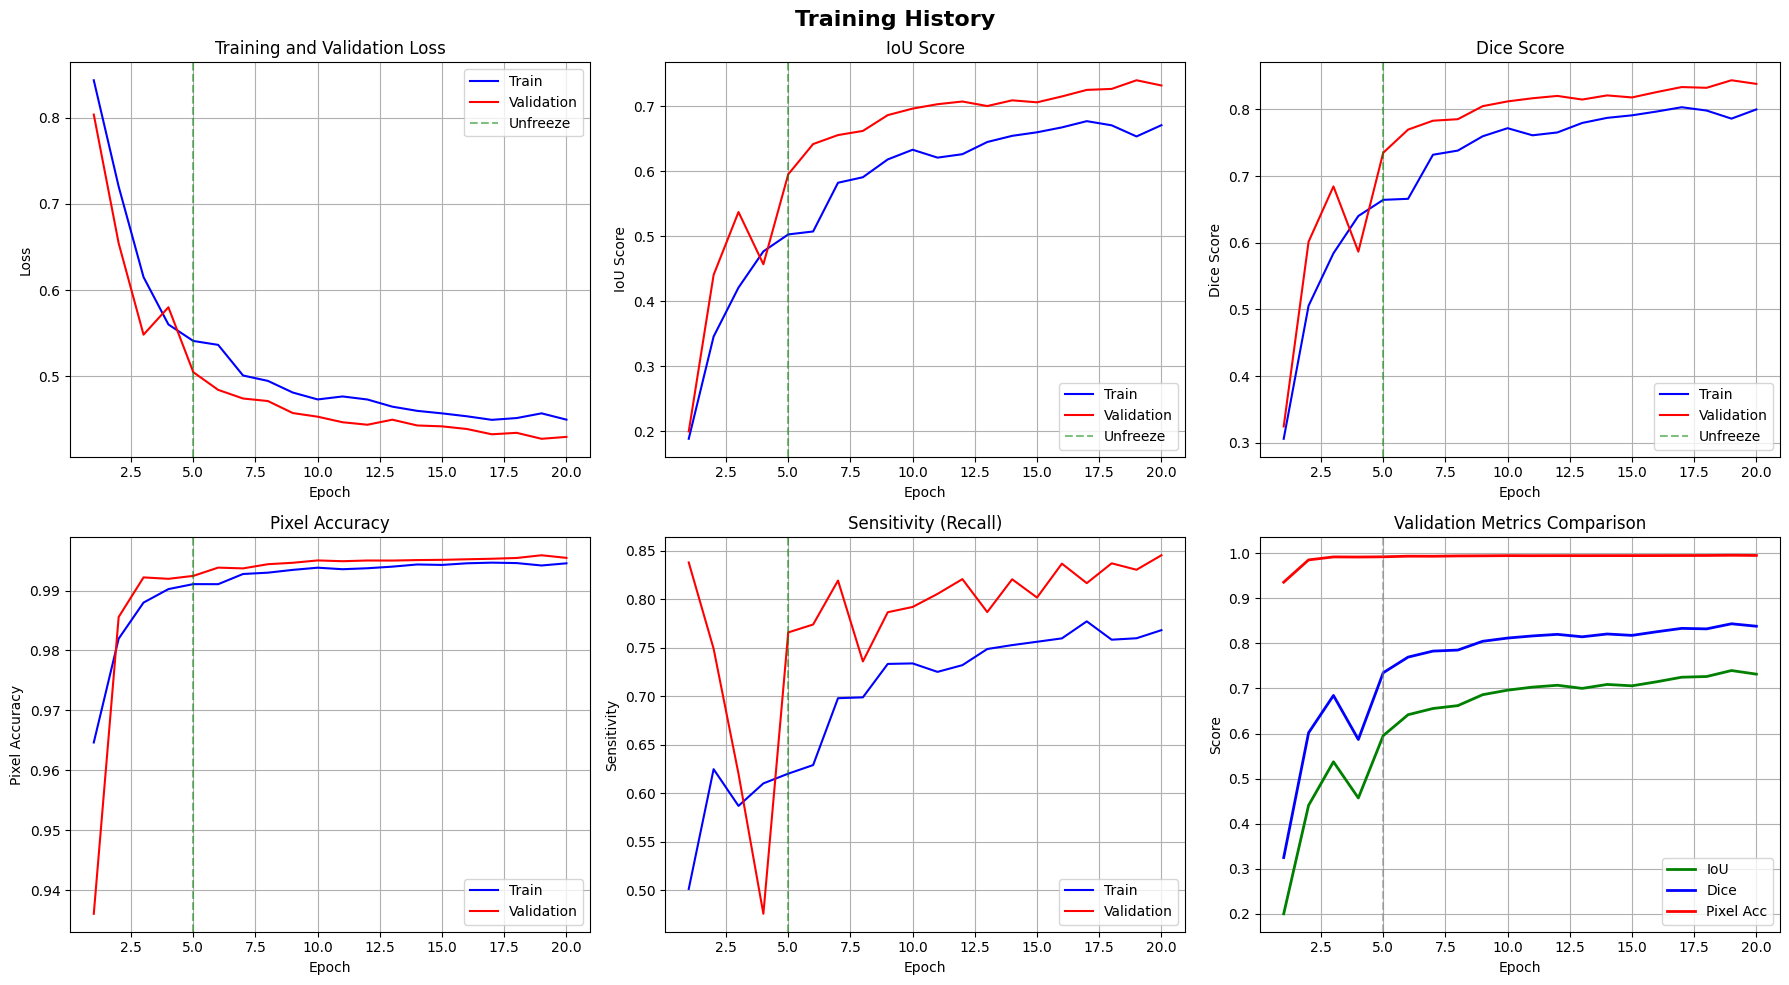


Testing on Test Set

Loading test dataset from: /kaggle/working/sam_baseline_img_test_dataset/test
Found 80 images in Glioma
Found 63 images in Meningioma
Found 54 images in Pituitary
Loaded 196 samples from test set
Class distribution: {'Glioma': 79, 'Meningioma': 63, 'Pituitary': 54}
Test samples: 196


Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Test Set Performance:
  Loss: 0.4111
  IoU: 0.7863
  Dice: 0.8751
  Pixel Accuracy: 0.9963
  Sensitivity: 0.8719

Visualizing segmentation results...


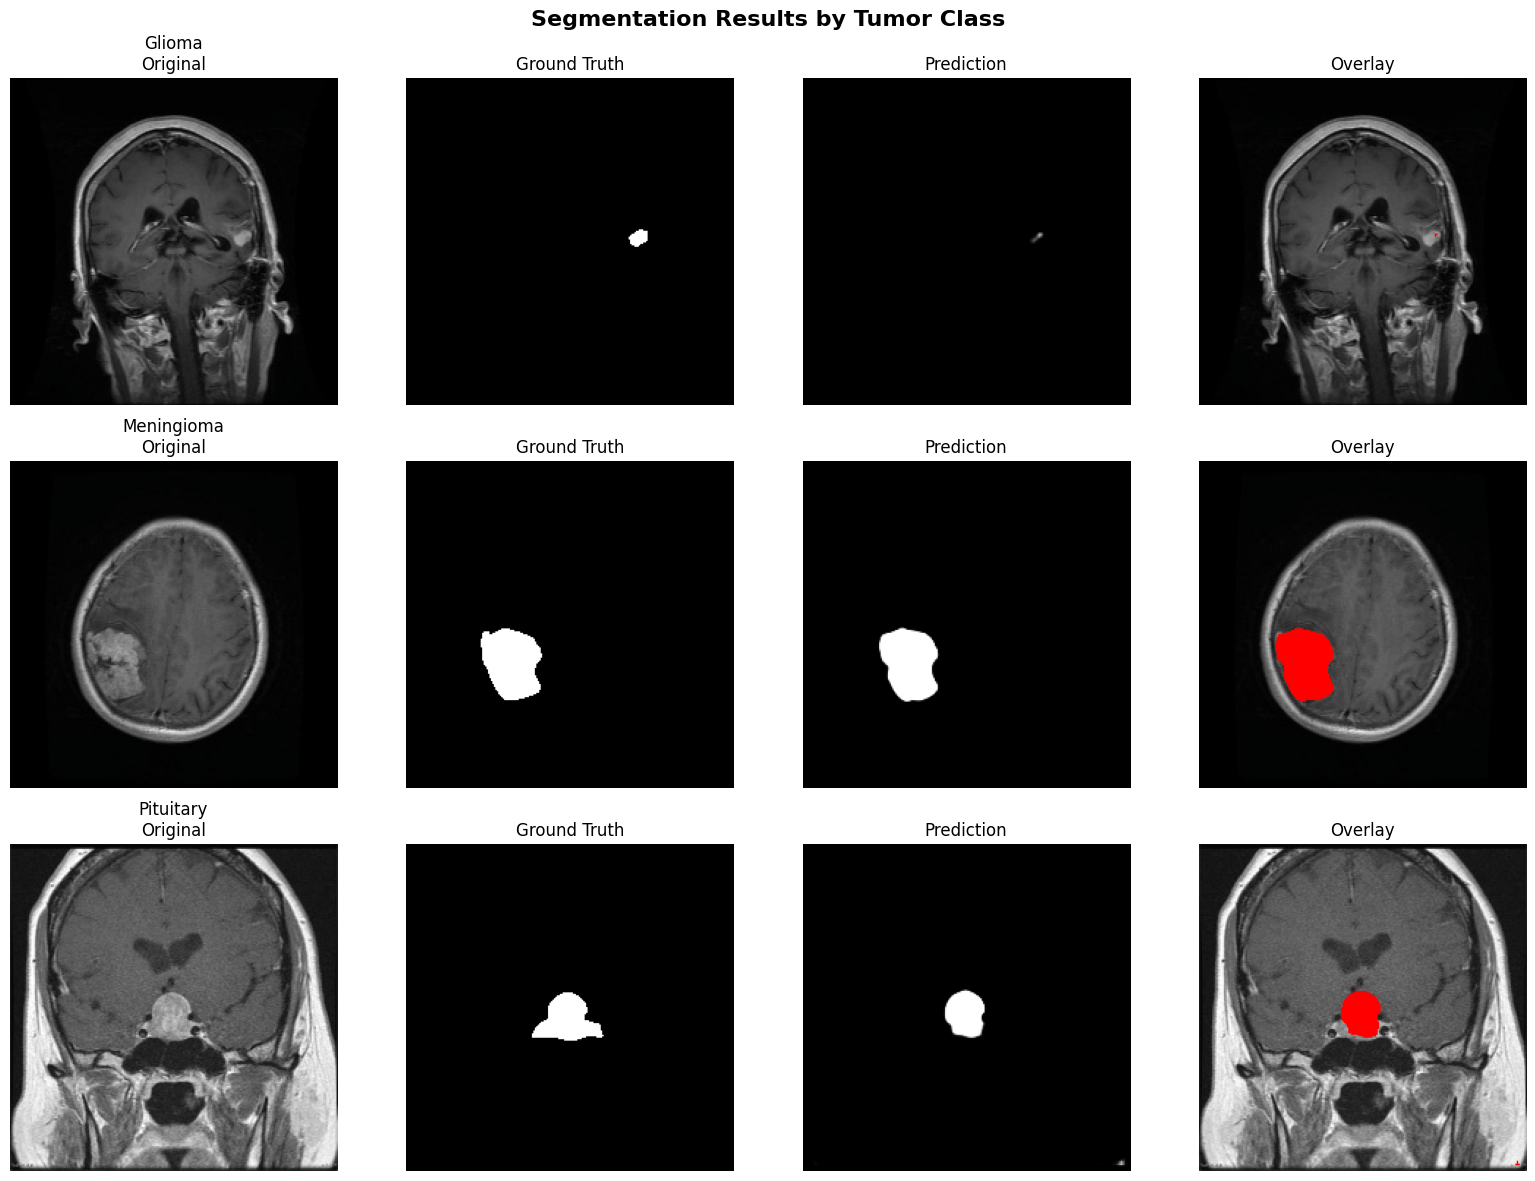

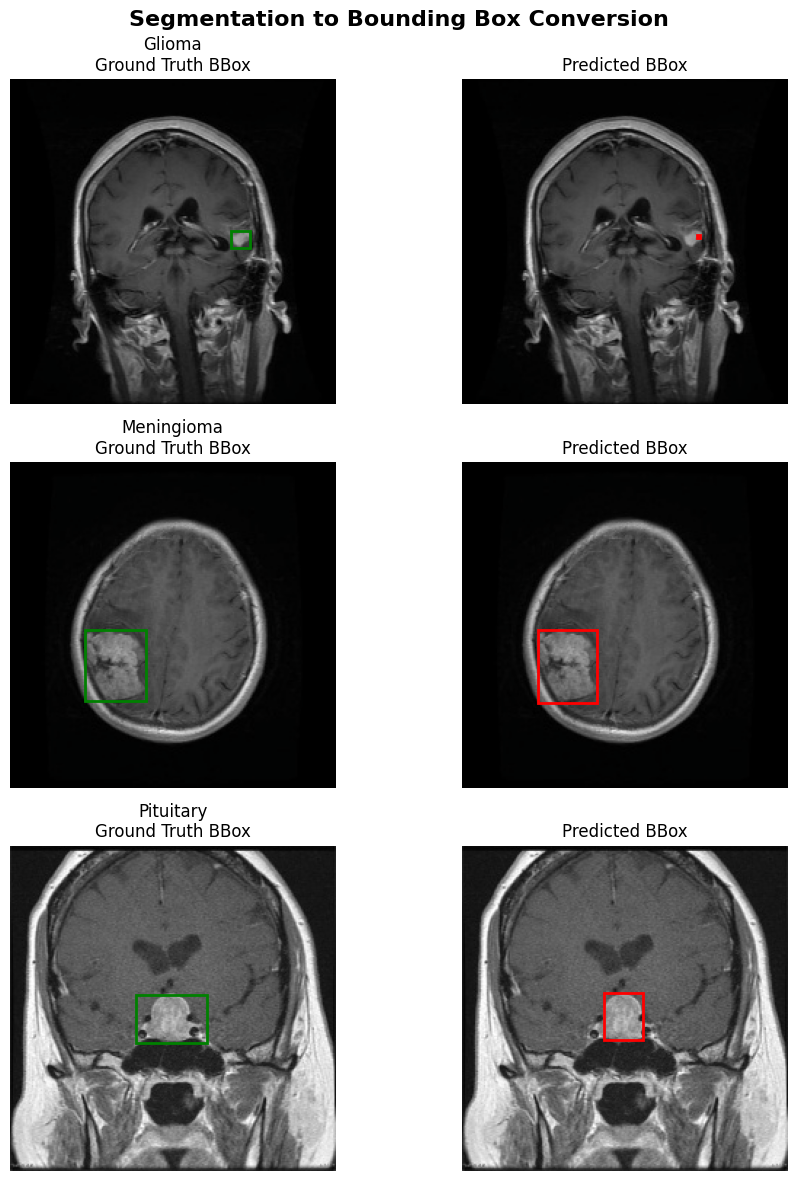


PHASE 2: Training on Combined Train+Val Set

Loading train dataset from: /kaggle/working/sam_baseline_img_test_dataset/train
Found 565 images in Glioma
Found 358 images in Meningioma
Found 437 images in Pituitary
Loaded 1359 samples from train set
Class distribution: {'Glioma': 564, 'Meningioma': 358, 'Pituitary': 437}
Combined train+val samples: 1761
Loading pretrained ResNet-101 from: /kaggle/input/resnet-101/pytorch/brain-tumour-ft/1/resnet101_brain_tumor_20251105_163019.pth
Loaded 624/626 layers

PHASE 1: Training with Frozen Encoder
Encoder frozen
Trainable parameters: 17,404,609

Epoch 1/5 (Frozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.8737, IoU: 0.1675, Dice: 0.2778
Val   - Loss: 0.8073, IoU: 0.3729, Dice: 0.5153

Epoch 2/5 (Frozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^^
^ ^ ^  ^^ ^  

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.7452, IoU: 0.3194, Dice: 0.4762
Val   - Loss: 0.6220, IoU: 0.5345, Dice: 0.6823

Epoch 3/5 (Frozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>self._shutdown_workers()

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.6081, IoU: 0.4331, Dice: 0.5983
Val   - Loss: 0.5529, IoU: 0.5115, Dice: 0.6643

Epoch 4/5 (Frozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.5527, IoU: 0.4823, Dice: 0.6449
Val   - Loss: 0.5095, IoU: 0.5872, Dice: 0.7275

Epoch 5/5 (Frozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    AssertionError: self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
can o

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.5292, IoU: 0.5197, Dice: 0.6790
Val   - Loss: 0.4826, IoU: 0.6348, Dice: 0.7659

PHASE 2: Training with Unfrozen Encoder
Encoder unfrozen
Trainable parameters: 59,904,769

Epoch 6/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.5272, IoU: 0.5179, Dice: 0.6749
Val   - Loss: 0.4610, IoU: 0.6881, Dice: 0.8065
✓ Saved best IoU model: 0.6881

Epoch 7/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4993, IoU: 0.5763, Dice: 0.7248
Val   - Loss: 0.4558, IoU: 0.6982, Dice: 0.8119
✓ Saved best IoU model: 0.6982

Epoch 8/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4770, IoU: 0.6238, Dice: 0.7640
Val   - Loss: 0.4406, IoU: 0.7322, Dice: 0.8356
✓ Saved best IoU model: 0.7322

Epoch 9/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4714, IoU: 0.6321, Dice: 0.7709
Val   - Loss: 0.4358, IoU: 0.7370, Dice: 0.8403
✓ Saved best IoU model: 0.7370

Epoch 10/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4664, IoU: 0.6411, Dice: 0.7771
Val   - Loss: 0.4362, IoU: 0.7299, Dice: 0.8368

Epoch 11/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4669, IoU: 0.6349, Dice: 0.7733
Val   - Loss: 0.4379, IoU: 0.7282, Dice: 0.8310

Epoch 12/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4603, IoU: 0.6496, Dice: 0.7841
Val   - Loss: 0.4337, IoU: 0.7291, Dice: 0.8361

Epoch 13/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4549, IoU: 0.6638, Dice: 0.7928
Val   - Loss: 0.4253, IoU: 0.7538, Dice: 0.8504
✓ Saved best IoU model: 0.7538

Epoch 14/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4482, IoU: 0.6772, Dice: 0.8047
Val   - Loss: 0.4174, IoU: 0.7703, Dice: 0.8646
✓ Saved best IoU model: 0.7703

Epoch 15/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4498, IoU: 0.6720, Dice: 0.8003
Val   - Loss: 0.4218, IoU: 0.7545, Dice: 0.8545

Epoch 16/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4429, IoU: 0.6891, Dice: 0.8127
Val   - Loss: 0.4150, IoU: 0.7725, Dice: 0.8662
✓ Saved best IoU model: 0.7725

Epoch 17/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4443, IoU: 0.6842, Dice: 0.8092
Val   - Loss: 0.4149, IoU: 0.7749, Dice: 0.8668
✓ Saved best IoU model: 0.7749

Epoch 18/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4428, IoU: 0.6871, Dice: 0.8114
Val   - Loss: 0.4181, IoU: 0.7632, Dice: 0.8590

Epoch 19/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4486, IoU: 0.6715, Dice: 0.7991
Val   - Loss: 0.4144, IoU: 0.7721, Dice: 0.8660

Epoch 20/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4450, IoU: 0.6798, Dice: 0.8057
Val   - Loss: 0.4116, IoU: 0.7832, Dice: 0.8717
✓ Saved best IoU model: 0.7832

Epoch 21/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4422, IoU: 0.6866, Dice: 0.8106
Val   - Loss: 0.4129, IoU: 0.7790, Dice: 0.8684

Epoch 22/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680><function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
             ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4382, IoU: 0.6975, Dice: 0.8183
Val   - Loss: 0.4077, IoU: 0.7903, Dice: 0.8781
✓ Saved best IoU model: 0.7903

Epoch 23/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4446, IoU: 0.6803, Dice: 0.8052
Val   - Loss: 0.4048, IoU: 0.7984, Dice: 0.8836
✓ Saved best IoU model: 0.7984

Epoch 24/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4402, IoU: 0.6923, Dice: 0.8134
Val   - Loss: 0.4112, IoU: 0.7806, Dice: 0.8708

Epoch 25/25 (Unfrozen)


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680><function _MultiProcessingDataLoaderIter.__del__ at 0x78fb49384680>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():
     if w.is_alive(): 
           ^ ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Train - Loss: 0.4456, IoU: 0.6774, Dice: 0.8026
Val   - Loss: 0.4071, IoU: 0.7938, Dice: 0.8791


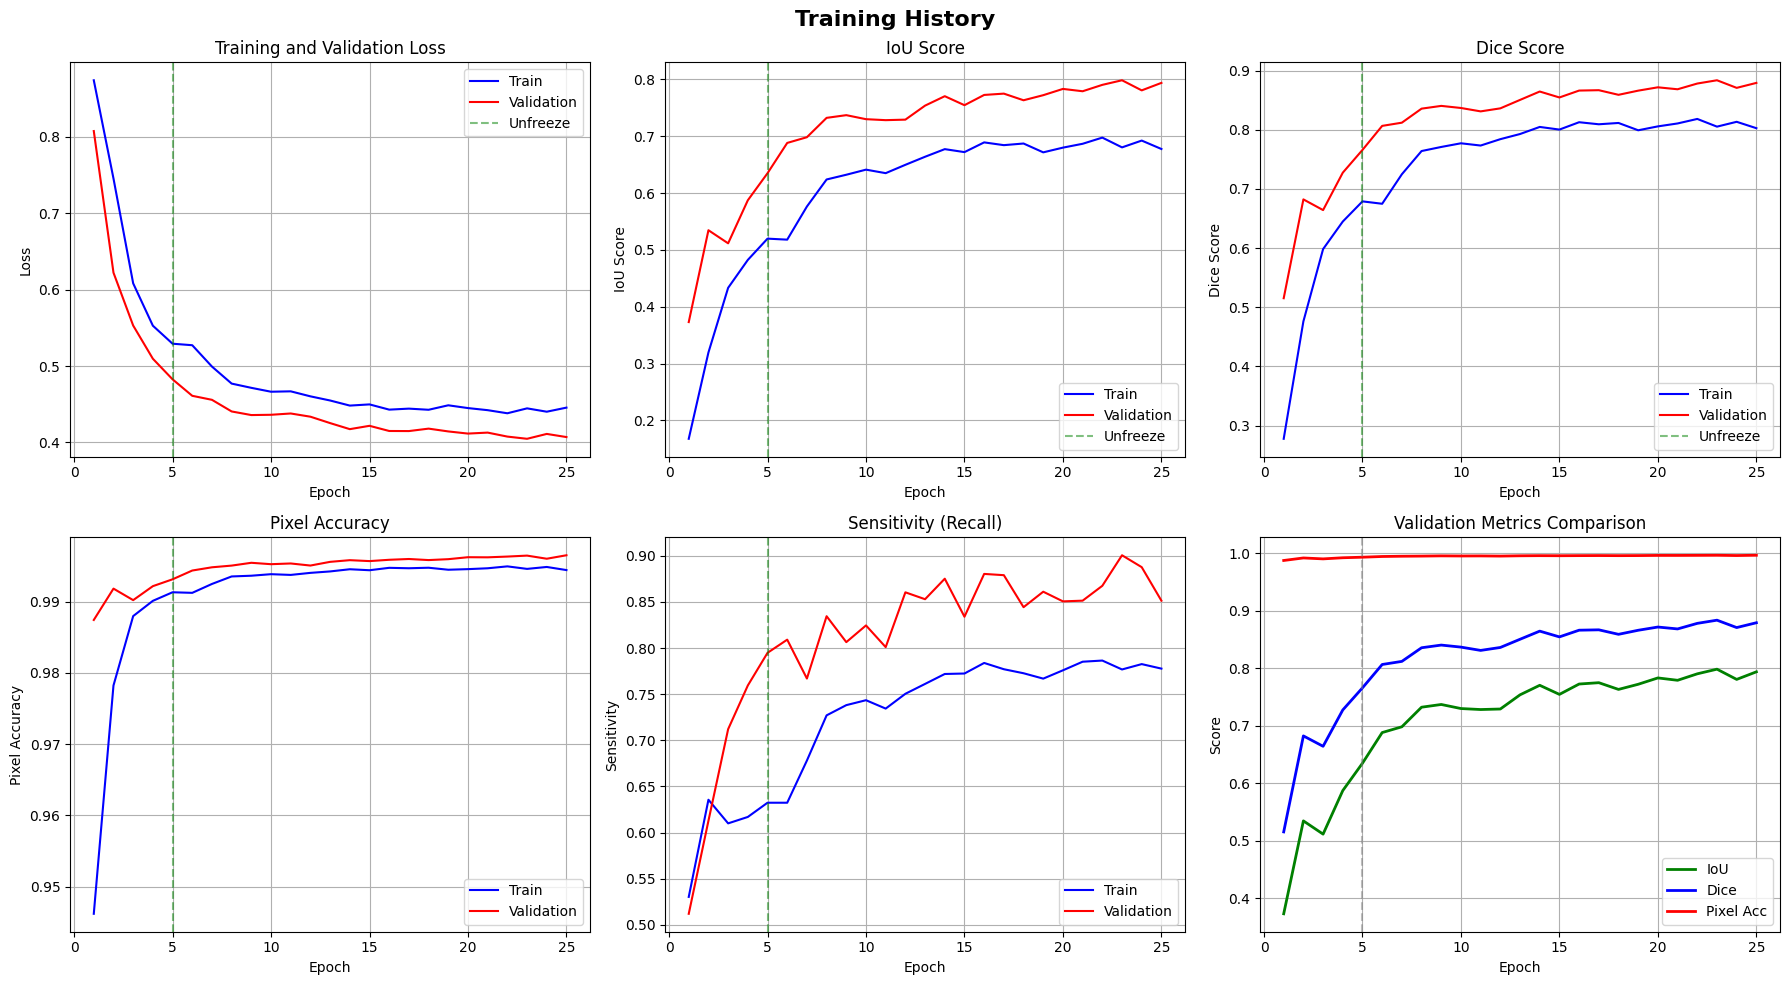


Final Test Set Evaluation


Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Final Test Performance (Full Training):
  Loss: 0.4071
  IoU: 0.7938
  Dice: 0.8791
  Pixel Accuracy: 0.9965
  Sensitivity: 0.8513

Visualizing final segmentation results...


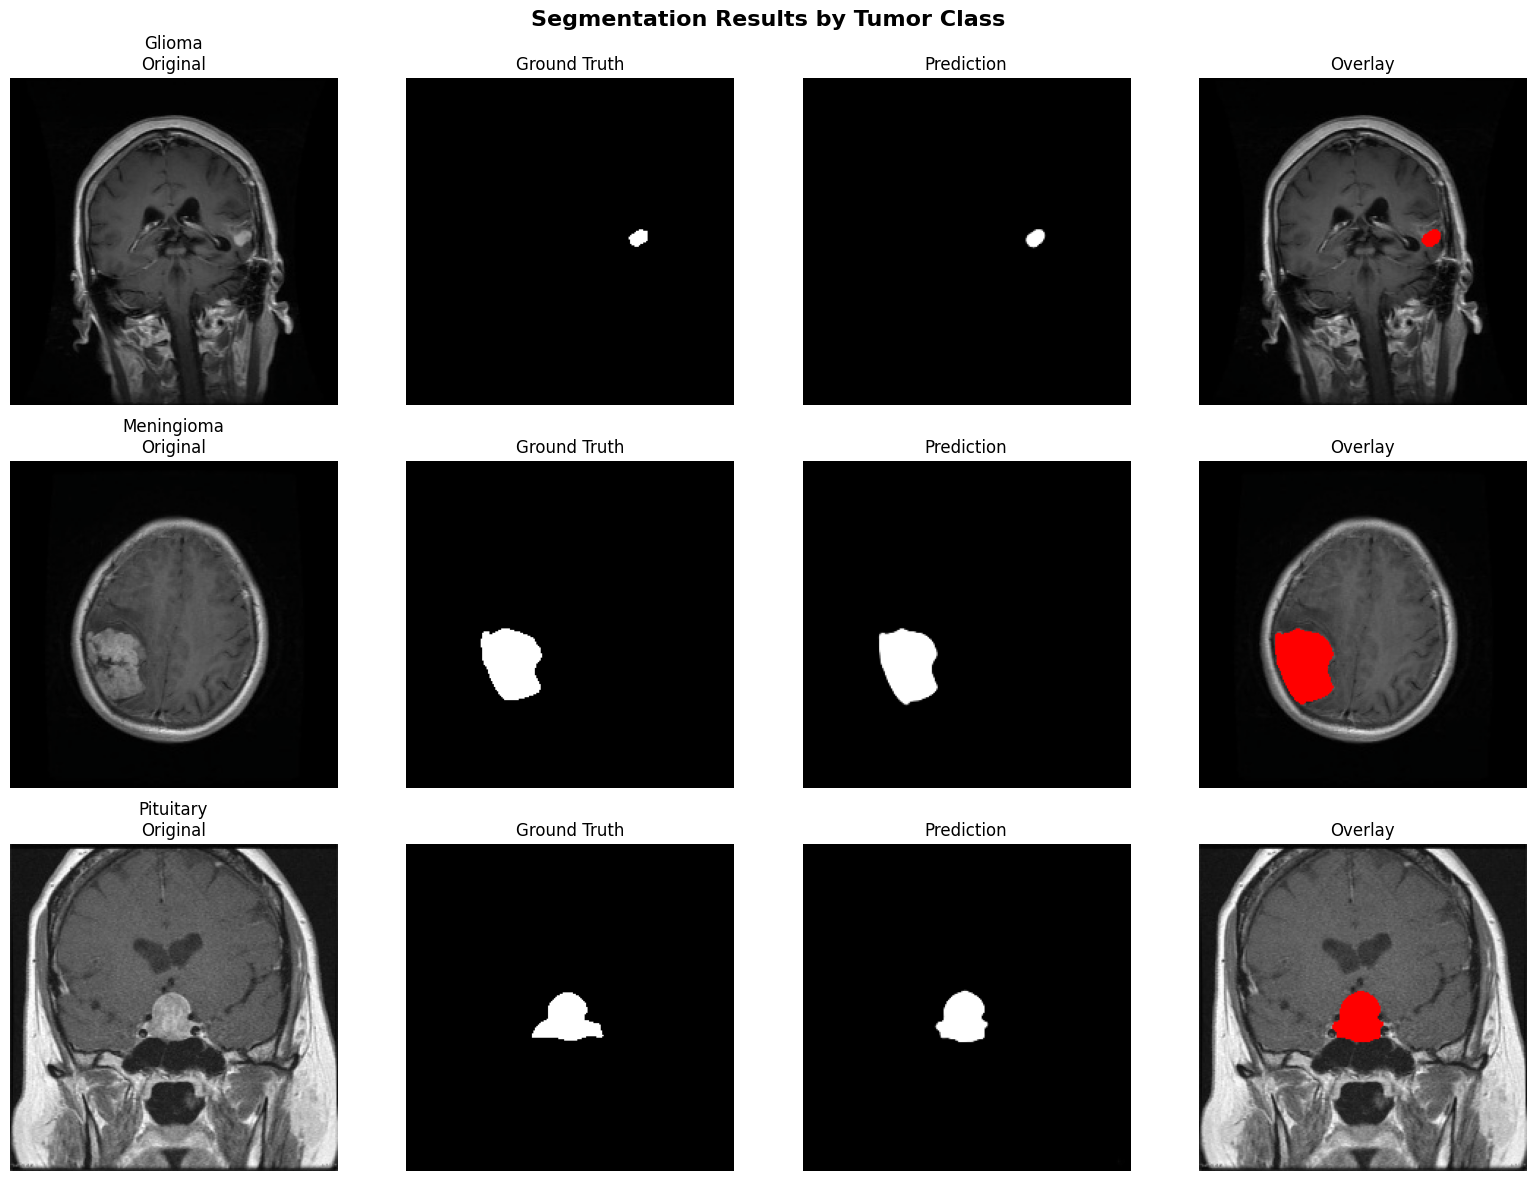

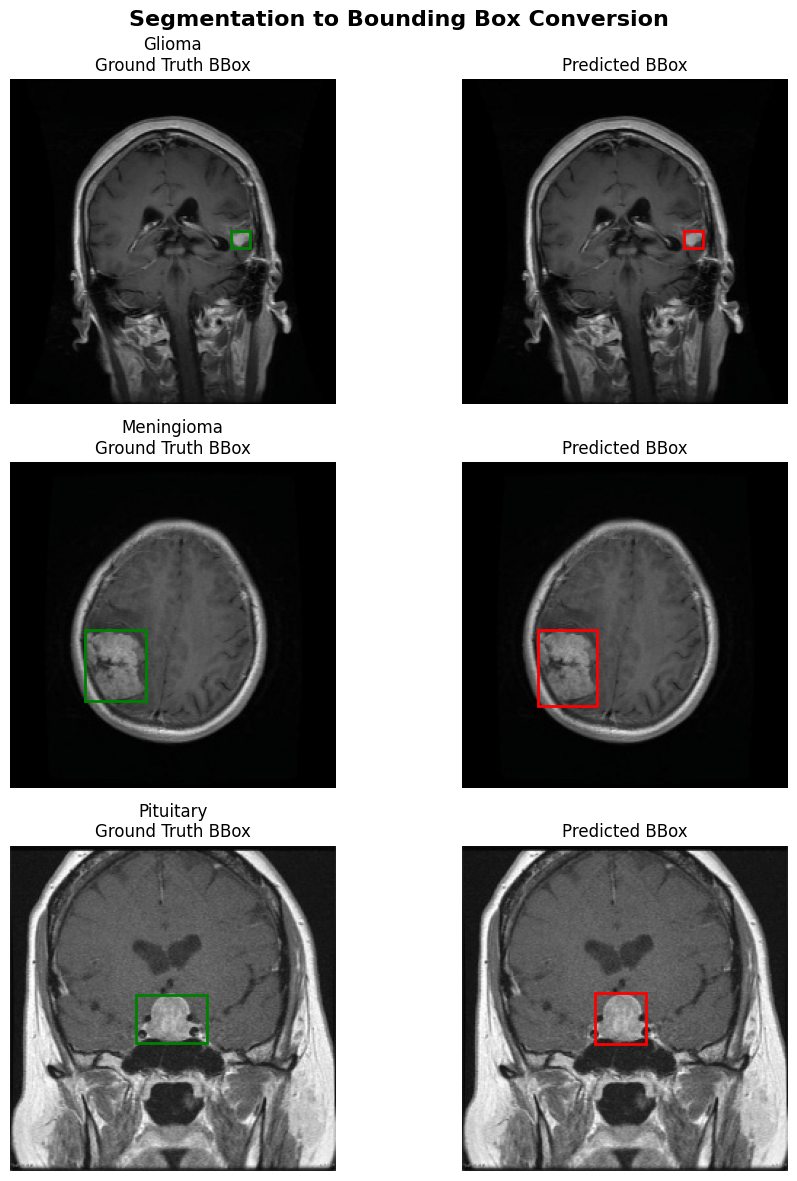


✓ TRAINING COMPLETED SUCCESSFULLY!
Results saved to: /kaggle/working/unet_outputs


In [24]:
# Training the U-Net architecture
# Complete Integrated U-Net Training Pipeline for Brain Tumor Segmentation
# Optimized for Kaggle T4 GPU with SAM-refined masks

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.models as models
import random
import json
from datetime import datetime
import gc

# Memory optimization for T4 GPU
torch.cuda.empty_cache()
gc.collect()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Enable cudNN optimization
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration class for training parameters"""
    
    # Paths
    DATA_ROOT = Path('/kaggle/working/sam_baseline_img_test_dataset')
    RESNET_WEIGHTS = Path('/kaggle/input/resnet-101/pytorch/brain-tumour-ft/1/resnet101_brain_tumor_20251105_163019.pth')
    OUTPUT_DIR = Path('/kaggle/working/unet_outputs')
    
    # Data parameters
    INPUT_SIZE = 224  # ResNet-101 standard input
    TUMOR_CLASSES = ['Glioma', 'Meningioma', 'Pituitary']
    
    # Training parameters - Optimized for T4 GPU
    BATCH_SIZE = 16  # Optimal for T4 GPU with mixed precision
    VAL_BATCH_SIZE = 32  # Can use larger batch for validation
    NUM_WORKERS = 2  # Kaggle has 2 CPU cores
    PIN_MEMORY = True
    
    # Training schedule
    FREEZE_EPOCHS = 5  # Epochs with frozen encoder
    UNFREEZE_EPOCHS = 15  # Additional epochs with unfrozen encoder
    TOTAL_EPOCHS = FREEZE_EPOCHS + UNFREEZE_EPOCHS
    
    # Learning rates
    LR_DECODER = 1e-3  # Learning rate for decoder (frozen encoder phase)
    LR_FULL = 1e-4  # Learning rate for full model (unfrozen phase)
    LR_MIN = 1e-6  # Minimum learning rate for scheduler
    
    # Mixed precision training
    USE_AMP = True  # Automatic Mixed Precision for T4 GPU
    
    # Validation
    VAL_FREQUENCY = 1  # Validate every N epochs
    SAVE_BEST = True
    
    def __init__(self):
        self.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
        self.CHECKPOINT_DIR = self.OUTPUT_DIR / 'checkpoints'
        self.CHECKPOINT_DIR.mkdir(exist_ok=True)
        self.VIS_DIR = self.OUTPUT_DIR / 'visualizations'
        self.VIS_DIR.mkdir(exist_ok=True)

config = Config()

# ============================================================================
# DATASET CLASS - FIXED FOR (1, 224, 224) BOOLEAN MASKS
# ============================================================================

class BrainTumorSegmentationDataset(Dataset):
    """
    Dataset class for brain tumor segmentation with SAM-refined masks
    Handles masks with shape (1, 224, 224) and dtype bool
    """
    
    def __init__(self, 
                 data_root: Path,
                 split: str,
                 transform=None,
                 cache_data: bool = False,
                 debug: bool = False):
        """
        Args:
            data_root: Root directory containing train/valid/test splits
            split: One of 'train', 'valid', 'test'
            transform: Albumentations transform pipeline
            cache_data: Whether to cache data in memory
            debug: Print debug information
        """
        self.data_root = data_root
        self.split = split
        self.transform = transform
        self.cache_data = cache_data
        self.debug = debug
        
        # Collect all image and mask paths
        self.image_paths = []
        self.mask_paths = []
        self.classes = []
        
        split_dir = data_root / split
        
        print(f"\nLoading {split} dataset from: {split_dir}")
        
        for tumor_class in config.TUMOR_CLASSES:
            class_dir = split_dir / tumor_class
            if not class_dir.exists():
                print(f"Warning: {class_dir} does not exist")
                continue
            
            # Look for annotated images
            images = sorted(list(class_dir.glob('*_annotated.jpg')))
            if not images:
                # Try alternative pattern
                images = sorted(list(class_dir.glob('*.jpg')))
            
            print(f"Found {len(images)} images in {tumor_class}")
            
            for img_path in images:
                # Try different mask naming patterns
                mask_candidates = [
                    class_dir / img_path.stem.replace('_annotated', '_mask.npy'),
                    class_dir / (img_path.stem.replace('_annotated', '') + '_mask.npy'),
                    class_dir / (img_path.stem + '.npy'),
                ]
                
                mask_path = None
                for candidate in mask_candidates:
                    if candidate.exists():
                        mask_path = candidate
                        break
                
                if mask_path:
                    self.image_paths.append(str(img_path))
                    self.mask_paths.append(str(mask_path))
                    self.classes.append(tumor_class)
        
        if len(self.image_paths) == 0:
            raise ValueError(f"No valid image-mask pairs found in {split_dir}")
        
        print(f"Loaded {len(self.image_paths)} samples from {split} set")
        class_dist = dict(zip(*np.unique(self.classes, return_counts=True)))
        print(f"Class distribution: {class_dist}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            raise ValueError(f"Failed to load image: {self.image_paths[idx]}")
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load mask
        mask = np.load(self.mask_paths[idx])
        
        # Handle mask format: (1, 224, 224) bool -> (224, 224) float32
        if len(mask.shape) == 3:
            if mask.shape[1] == 224 and mask.shape[2] == 224:
                mask = mask[0]  # Remove channel dimension to get (224, 224)
            else:
                mask = mask[:, :, 0]  # Remove channel dimension

        # if (len(mask.shape) > 2): print(f"Mask shape for case [(224,224,1)] after : {mask.shape}\n") #debug
        
        # Convert boolean to float
        if mask.dtype == bool:
            mask = mask.astype(np.float32)
        else:
            mask = mask.astype(np.float32)
            # Ensure binary
            if mask.max() > 1:
                mask = (mask > 0).astype(np.float32)
                
        # IMPORTANT: Resize both image and mask to 224x224 BEFORE transforms
        if image.shape[:2] != (224, 224):
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
        
        if mask.shape != (224, 224):
            mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)
            # Ensure mask remains binary after resize
            mask = (mask > 0.5).astype(np.float32)

        # if len(mask.shape) > 2: print(f"Mask shape before transform: {mask.shape} and mask_path: {self.mask_paths[idx]}\n"); #debug
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # This will be a tensor (3, 224, 224)
            mask = augmented['mask']    # This will be a tensor (224, 224)

            # Add channel dimension to mask after transform
            if len(mask.shape) == 2:
                mask = mask.unsqueeze(0)  # Add channel dimension -> (1, 224, 224)
            # if mask.shape != (1,224,224): print(f"Mask shape after transform: {mask.shape}\n"); #debug

        else:
            # Manual conversion without transforms
            image = image.astype(np.float32) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1)  # (3, 224, 224)
            mask = torch.from_numpy(mask).unsqueeze(0)  # (1, 224, 224)

        # Final validation
        assert image.shape == (3, 224, 224), f"Final image shape mismatch: {image.shape}"
        assert mask.shape == (1, 224, 224), f"Final mask shape mismatch: {mask.shape}, mask_path:{self.mask_paths[idx]}"
        
        return image.float(), mask.float(), self.classes[idx]

# ============================================================================
# DATA AUGMENTATION
# ============================================================================

def get_transforms():
    """Get data augmentation transforms that properly handle masks"""
    
    train_transform = A.Compose([
        # Ensure input is correct dtype
        A.Lambda(image=lambda x, **kwargs: x.astype(np.uint8), 
                mask=lambda x, **kwargs: x.astype(np.float32)),
        
        # Spatial transforms
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            mask_value=0,
            p=0.5
        ),
        
        # Elastic deformations
        A.OneOf([
            A.ElasticTransform(
                alpha=120, 
                sigma=120 * 0.05, 
                alpha_affine=120 * 0.03,
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                mask_value=0,
                p=1.0
            ),
            A.GridDistortion(
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                mask_value=0,
                p=1.0
            ),
        ], p=0.3),
        
        # Only apply to image, not mask
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
        ], p=0.3),
        
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),
        ], p=0.3),
        
        # Normalize and convert to tensor
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])
    
    val_transform = A.Compose([
        A.Lambda(image=lambda x, **kwargs: x.astype(np.uint8), 
                mask=lambda x, **kwargs: x.astype(np.float32)),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])
    
    return train_transform, val_transform

# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

class ResNetEncoder(nn.Module):
    """ResNet-101 encoder with pretrained weights"""
    
    def __init__(self, pretrained_path: Path = None):
        super(ResNetEncoder, self).__init__()
        
        # Load base ResNet-101
        resnet = models.resnet101(weights=None)
        
        # Load pretrained weights if available
        if pretrained_path and pretrained_path.exists():
            print(f"Loading pretrained ResNet-101 from: {pretrained_path}")
            checkpoint = torch.load(pretrained_path, map_location='cpu', weights_only=False)
            
            # Handle different checkpoint formats
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    state_dict = checkpoint['model_state_dict']
                elif 'state_dict' in checkpoint:
                    state_dict = checkpoint['state_dict']
                else:
                    state_dict = checkpoint
            else:
                state_dict = checkpoint
            
            # Load weights (ignoring FC layer)
            resnet_dict = resnet.state_dict()
            pretrained_dict = {k: v for k, v in state_dict.items() 
                             if k in resnet_dict and 'fc' not in k}
            resnet_dict.update(pretrained_dict)
            resnet.load_state_dict(resnet_dict, strict=False)
            print(f"Loaded {len(pretrained_dict)}/{len(resnet_dict)} layers")
        else:
            print("Using ImageNet pretrained ResNet-101")
            resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
        
        # Extract encoder layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        self.channels = [64, 256, 512, 1024, 2048]
    
    def forward(self, x):
        x0 = self.relu(self.bn1(self.conv1(x)))
        x1 = self.layer1(self.maxpool(x0))
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return [x0, x1, x2, x3, x4]

class DecoderBlock(nn.Module):
    """Decoder block with skip connection"""
    
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv_block = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x, skip):
        x = self.upconv(x)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv_block(x)

class UNetDecoder(nn.Module):
    """U-Net decoder with progressive upsampling"""
    
    def __init__(self, encoder_channels, num_classes=1):
        super(UNetDecoder, self).__init__()
        self.decoder4 = DecoderBlock(encoder_channels[4], encoder_channels[3], 512)
        self.decoder3 = DecoderBlock(512, encoder_channels[2], 256)
        self.decoder2 = DecoderBlock(256, encoder_channels[1], 128)
        self.decoder1 = DecoderBlock(128, encoder_channels[0], 64)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, 1)
        )
    
    def forward(self, features):
        x0, x1, x2, x3, x4 = features
        d4 = self.decoder4(x4, x3)
        d3 = self.decoder3(d4, x2)
        d2 = self.decoder2(d3, x1)
        d1 = self.decoder1(d2, x0)
        out = self.final_conv(d1)
        return F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=True)

class ResNetUNet(nn.Module):
    """Complete U-Net with ResNet-101 encoder"""
    
    def __init__(self, pretrained_encoder_path: Path = None, num_classes: int = 1):
        super(ResNetUNet, self).__init__()
        self.encoder = ResNetEncoder(pretrained_encoder_path)
        self.decoder = UNetDecoder(self.encoder.channels, num_classes)
    
    def forward(self, x):
        features = self.encoder(x)
        out = self.decoder(features)
        return out
    
    def freeze_encoder(self):
        """Freeze encoder parameters"""
        for param in self.encoder.parameters():
            param.requires_grad = False
        print("Encoder frozen")
    
    def unfreeze_encoder(self):
        """Unfreeze encoder parameters"""
        for param in self.encoder.parameters():
            param.requires_grad = True
        print("Encoder unfrozen")
    
    def get_trainable_params(self):
        """Get number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# ============================================================================
# LOSSES AND METRICS
# ============================================================================

class DiceLoss(nn.Module):
    """Dice loss for segmentation"""
    
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice

class CombinedSegmentationLoss(nn.Module):
    """Combined BCE + Dice loss"""
    
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedSegmentationLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss
        self.dice = DiceLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
    
    def forward(self, pred, target):
        bce_loss = self.bce(torch.sigmoid(pred), target)
        dice_loss = self.dice(torch.sigmoid(pred), target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

class SegmentationMetrics:
    """Metrics for segmentation evaluation"""
    
    @staticmethod
    def iou_score(pred, target, threshold=0.5, smooth=1e-6):
        """Calculate IoU score"""
        pred = (pred > threshold).float()
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        return (intersection + smooth) / (union + smooth)
    
    @staticmethod
    def dice_score(pred, target, threshold=0.5, smooth=1e-6):
        """Calculate Dice score"""
        pred = (pred > threshold).float()
        intersection = (pred * target).sum()
        return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    @staticmethod
    def pixel_accuracy(pred, target, threshold=0.5):
        """Calculate pixel-wise accuracy"""
        pred = (pred > threshold).float()
        correct = (pred == target).float().sum()
        total = target.numel()
        return correct / total
    
    @staticmethod
    def sensitivity(pred, target, threshold=0.5, smooth=1e-6):
        """Calculate sensitivity (recall)"""
        pred = (pred > threshold).float()
        tp = (pred * target).sum()
        fn = ((1 - pred) * target).sum()
        return (tp + smooth) / (tp + fn + smooth)

# ============================================================================
# TRAINING CLASS
# ============================================================================

class Trainer:
    """Training pipeline with mixed precision and progressive unfreezing"""
    
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.device = device
        
        # Move model to device
        self.model = self.model.to(self.device)
        
        # Mixed precision
        self.scaler = GradScaler() if config.USE_AMP else None
        
        # History tracking
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_iou': [], 'val_iou': [],
            'train_dice': [], 'val_dice': [],
            'train_pixel_acc': [], 'val_pixel_acc': [],
            'train_sensitivity': [], 'val_sensitivity': []
        }
        
        self.best_val_iou = 0.0
        self.best_val_dice = 0.0
    
    def train_epoch(self, dataloader, criterion, optimizer):
        """Train for one epoch"""
        self.model.train()
        
        running_loss = 0.0
        running_iou = 0.0
        running_dice = 0.0
        running_pixel_acc = 0.0
        running_sensitivity = 0.0
        
        pbar = tqdm(dataloader, desc='Training', leave=False)
        for batch_idx, (images, masks, _) in enumerate(pbar):
            images = images.to(self.device)
            masks = masks.to(self.device)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            if self.config.USE_AMP:
                with autocast():
                    outputs = self.model(images)
                    loss = criterion(outputs, masks)
                
                # Backward pass
                self.scaler.scale(loss).backward()
                self.scaler.step(optimizer)
                self.scaler.update()
            else:
                outputs = self.model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
            
            # Calculate metrics
            with torch.no_grad():
                running_loss += loss.item()
                outputs_sigmoid = torch.sigmoid(outputs)  # Apply sigmoid for metrics
                running_iou += SegmentationMetrics.iou_score(outputs_sigmoid, masks).item()
                running_dice += SegmentationMetrics.dice_score(outputs_sigmoid, masks).item()
                running_pixel_acc += SegmentationMetrics.pixel_accuracy(outputs_sigmoid, masks).item()
                running_sensitivity += SegmentationMetrics.sensitivity(outputs_sigmoid, masks).item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'iou': running_iou / (batch_idx + 1)
            })
            
            # Clear cache periodically
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
        
        n_batches = len(dataloader)
        metrics = {
            'loss': running_loss / n_batches,
            'iou': running_iou / n_batches,
            'dice': running_dice / n_batches,
            'pixel_acc': running_pixel_acc / n_batches,
            'sensitivity': running_sensitivity / n_batches
        }
        
        return metrics
    
    @torch.no_grad()
    def validate_epoch(self, dataloader, criterion):
        """Validate for one epoch"""
        self.model.eval()
        
        running_loss = 0.0
        running_iou = 0.0
        running_dice = 0.0
        running_pixel_acc = 0.0
        running_sensitivity = 0.0
        
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        for batch_idx, (images, masks, _) in enumerate(pbar):
            images = images.to(self.device)
            masks = masks.to(self.device)
            
            outputs = self.model(images)
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            running_loss += loss.item()
            outputs_sigmoid = torch.sigmoid(outputs)  # Apply sigmoid for metrics
            running_iou += SegmentationMetrics.iou_score(outputs_sigmoid, masks).item()
            running_dice += SegmentationMetrics.dice_score(outputs_sigmoid, masks).item()
            running_pixel_acc += SegmentationMetrics.pixel_accuracy(outputs_sigmoid, masks).item()
            running_sensitivity += SegmentationMetrics.sensitivity(outputs_sigmoid, masks).item()
            
            pbar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'iou': running_iou / (batch_idx + 1)
            })
        
        n_batches = len(dataloader)
        metrics = {
            'loss': running_loss / n_batches,
            'iou': running_iou / n_batches,
            'dice': running_dice / n_batches,
            'pixel_acc': running_pixel_acc / n_batches,
            'sensitivity': running_sensitivity / n_batches
        }
        
        return metrics
    
    def train(self, train_loader, val_loader, epochs, freeze_epochs, lr_decoder, lr_full):
        """Complete training pipeline with progressive unfreezing"""
        
        criterion = CombinedSegmentationLoss(bce_weight=0.5, dice_weight=0.5)
        
        # Phase 1: Frozen encoder
        print("\n" + "="*60)
        print("PHASE 1: Training with Frozen Encoder")
        print("="*60)
        
        self.model.freeze_encoder()
        print(f"Trainable parameters: {self.model.get_trainable_params():,}")
        
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), 
                               lr=lr_decoder, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=freeze_epochs)
        
        for epoch in range(freeze_epochs):
            print(f"\nEpoch {epoch+1}/{freeze_epochs} (Frozen)")
            
            # Train
            train_metrics = self.train_epoch(train_loader, criterion, optimizer)
            
            # Validate
            val_metrics = self.validate_epoch(val_loader, criterion)
            
            # Update history
            for key in ['loss', 'iou', 'dice', 'pixel_acc', 'sensitivity']:
                self.history[f'train_{key}'].append(train_metrics[key])
                self.history[f'val_{key}'].append(val_metrics[key])
            
            # Print metrics
            print(f"Train - Loss: {train_metrics['loss']:.4f}, IoU: {train_metrics['iou']:.4f}, "
                  f"Dice: {train_metrics['dice']:.4f}")
            print(f"Val   - Loss: {val_metrics['loss']:.4f}, IoU: {val_metrics['iou']:.4f}, "
                  f"Dice: {val_metrics['dice']:.4f}")
            
            scheduler.step()
        
        # Phase 2: Unfrozen encoder
        print("\n" + "="*60)
        print("PHASE 2: Training with Unfrozen Encoder")
        print("="*60)
        
        self.model.unfreeze_encoder()
        print(f"Trainable parameters: {self.model.get_trainable_params():,}")
        
        optimizer = optim.AdamW(self.model.parameters(), lr=lr_full, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                         factor=0.5, patience=3, 
                                                         verbose=True)
        
        remaining_epochs = epochs - freeze_epochs
        for epoch in range(remaining_epochs):
            print(f"\nEpoch {freeze_epochs + epoch + 1}/{epochs} (Unfrozen)")
            
            # Train
            train_metrics = self.train_epoch(train_loader, criterion, optimizer)
            
            # Validate
            val_metrics = self.validate_epoch(val_loader, criterion)
            
            # Update history
            for key in ['loss', 'iou', 'dice', 'pixel_acc', 'sensitivity']:
                self.history[f'train_{key}'].append(train_metrics[key])
                self.history[f'val_{key}'].append(val_metrics[key])
            
            # Print metrics
            print(f"Train - Loss: {train_metrics['loss']:.4f}, IoU: {train_metrics['iou']:.4f}, "
                  f"Dice: {train_metrics['dice']:.4f}")
            print(f"Val   - Loss: {val_metrics['loss']:.4f}, IoU: {val_metrics['iou']:.4f}, "
                  f"Dice: {val_metrics['dice']:.4f}")
            
            # Update scheduler
            scheduler.step(val_metrics['iou'])
            
            # Save best model
            if val_metrics['iou'] > self.best_val_iou:
                self.best_val_iou = val_metrics['iou']
                self.save_checkpoint('best_iou_model.pth', epoch + freeze_epochs + 1, val_metrics)
                print(f"✓ Saved best IoU model: {self.best_val_iou:.4f}")
            
            if val_metrics['dice'] > self.best_val_dice:
                self.best_val_dice = val_metrics['dice']
                self.save_checkpoint('best_dice_model.pth', epoch + freeze_epochs + 1, val_metrics)
    
    def save_checkpoint(self, filename, epoch, metrics):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'metrics': metrics,
            'history': self.history
        }
        torch.save(checkpoint, self.config.CHECKPOINT_DIR / filename)
    
    def plot_training_history(self):
        """Plot training metrics"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        epochs = range(1, len(self.history['train_loss']) + 1)
        
        # Loss
        axes[0, 0].plot(epochs, self.history['train_loss'], 'b-', label='Train')
        axes[0, 0].plot(epochs, self.history['val_loss'], 'r-', label='Validation')
        axes[0, 0].axvline(x=config.FREEZE_EPOCHS, color='g', linestyle='--', alpha=0.5, label='Unfreeze')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # IoU
        axes[0, 1].plot(epochs, self.history['train_iou'], 'b-', label='Train')
        axes[0, 1].plot(epochs, self.history['val_iou'], 'r-', label='Validation')
        axes[0, 1].axvline(x=config.FREEZE_EPOCHS, color='g', linestyle='--', alpha=0.5, label='Unfreeze')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('IoU Score')
        axes[0, 1].set_title('IoU Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Dice
        axes[0, 2].plot(epochs, self.history['train_dice'], 'b-', label='Train')
        axes[0, 2].plot(epochs, self.history['val_dice'], 'r-', label='Validation')
        axes[0, 2].axvline(x=config.FREEZE_EPOCHS, color='g', linestyle='--', alpha=0.5, label='Unfreeze')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Dice Score')
        axes[0, 2].set_title('Dice Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True)
        
        # Pixel Accuracy
        axes[1, 0].plot(epochs, self.history['train_pixel_acc'], 'b-', label='Train')
        axes[1, 0].plot(epochs, self.history['val_pixel_acc'], 'r-', label='Validation')
        axes[1, 0].axvline(x=config.FREEZE_EPOCHS, color='g', linestyle='--', alpha=0.5)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Pixel Accuracy')
        axes[1, 0].set_title('Pixel Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # Sensitivity
        axes[1, 1].plot(epochs, self.history['train_sensitivity'], 'b-', label='Train')
        axes[1, 1].plot(epochs, self.history['val_sensitivity'], 'r-', label='Validation')
        axes[1, 1].axvline(x=config.FREEZE_EPOCHS, color='g', linestyle='--', alpha=0.5)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Sensitivity')
        axes[1, 1].set_title('Sensitivity (Recall)')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        # Combined metrics
        axes[1, 2].plot(epochs, self.history['val_iou'], 'g-', label='IoU', linewidth=2)
        axes[1, 2].plot(epochs, self.history['val_dice'], 'b-', label='Dice', linewidth=2)
        axes[1, 2].plot(epochs, self.history['val_pixel_acc'], 'r-', label='Pixel Acc', linewidth=2)
        axes[1, 2].axvline(x=config.FREEZE_EPOCHS, color='gray', linestyle='--', alpha=0.5)
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Score')
        axes[1, 2].set_title('Validation Metrics Comparison')
        axes[1, 2].legend()
        axes[1, 2].grid(True)
        
        plt.suptitle('Training History', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(config.VIS_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
        plt.show()

# ============================================================================
# VISUALIZATION
# ============================================================================

class Visualizer:
    """Visualization utilities"""
    
    @staticmethod
    def mask_to_bbox(mask, threshold=0.5):
        """Convert binary mask to bounding box"""
        # Threshold mask
        binary_mask = (mask > threshold).astype(np.uint8)
        
        if binary_mask.sum() == 0:
            return None
        
        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) == 0:
            return None
        
        # Get largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        return [x, y, x + w, y + h]
    
    @staticmethod
    def visualize_segmentation_results(model, dataloader, device, num_samples=1):
        """Visualize segmentation results for each class"""
        model.eval()
        
        # Collect samples for each class
        class_samples = {cls: [] for cls in config.TUMOR_CLASSES}
        
        with torch.no_grad():
            for images, masks, classes in dataloader:
                images = images.to(device)
                outputs = model(images)
                outputs = torch.sigmoid(outputs)  # Add sigmoid here for visualization
                
                for i in range(len(classes)):
                    cls = classes[i]
                    if len(class_samples[cls]) < num_samples:
                        class_samples[cls].append({
                            'image': images[i].cpu(),
                            'mask': masks[i].cpu(),
                            'pred': outputs[i].cpu(),
                        })
                
                # Check if we have enough samples
                if all(len(samples) >= num_samples for samples in class_samples.values()):
                    break
        
        # Plot results
        fig, axes = plt.subplots(len(config.TUMOR_CLASSES), 4, figsize=(16, 12))
        
        for cls_idx, (cls_name, samples) in enumerate(class_samples.items()):
            if samples:
                sample = samples[0]
                
                # Prepare images
                img = sample['image'].permute(1, 2, 0).numpy()
                # Denormalize
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = img * std + mean
                img = np.clip(img, 0, 1)
                
                mask = sample['mask'].squeeze().numpy()
                pred = sample['pred'].squeeze().numpy()
                
                # Original image
                axes[cls_idx, 0].imshow(img)
                axes[cls_idx, 0].set_title(f'{cls_name}\nOriginal')
                axes[cls_idx, 0].axis('off')
                
                # Ground truth mask
                axes[cls_idx, 1].imshow(mask, cmap='gray')
                axes[cls_idx, 1].set_title('Ground Truth')
                axes[cls_idx, 1].axis('off')
                
                # Predicted mask
                axes[cls_idx, 2].imshow(pred, cmap='gray', vmin=0, vmax=1)
                axes[cls_idx, 2].set_title('Prediction')
                axes[cls_idx, 2].axis('off')
                
                # Overlay
                overlay = img.copy()
                pred_binary = (pred > 0.5).astype(np.float32)
                overlay[:, :, 0] = np.where(pred_binary > 0, 1, overlay[:, :, 0])
                overlay[:, :, 1] = np.where(pred_binary > 0, 0, overlay[:, :, 1])
                overlay[:, :, 2] = np.where(pred_binary > 0, 0, overlay[:, :, 2])
                
                axes[cls_idx, 3].imshow(overlay)
                axes[cls_idx, 3].set_title('Overlay')
                axes[cls_idx, 3].axis('off')
        
        plt.suptitle('Segmentation Results by Tumor Class', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(config.VIS_DIR / 'segmentation_results.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def visualize_bbox_conversion(model, dataloader, device):
        """Visualize mask to bounding box conversion"""
        model.eval()
        
        # Get one sample per class
        class_samples = {}
        
        with torch.no_grad():
            for images, masks, classes in dataloader:
                images = images.to(device)
                outputs = model(images)
                outputs = torch.sigmoid(outputs)  # Add sigmoid here for visualization
                
                for i in range(len(classes)):
                    cls = classes[i]
                    if cls not in class_samples:
                        class_samples[cls] = {
                            'image': images[i].cpu(),
                            'mask': masks[i].cpu(),
                            'pred': outputs[i].cpu(),
                        }
                
                if len(class_samples) == len(config.TUMOR_CLASSES):
                    break
        
        # Plot bbox conversion
        fig, axes = plt.subplots(len(config.TUMOR_CLASSES), 2, 
                                 figsize=(10, len(config.TUMOR_CLASSES) * 4))
        
        if len(config.TUMOR_CLASSES) == 1:
            axes = axes.reshape(1, -1)
        
        for idx, (cls_name, sample) in enumerate(class_samples.items()):
            # Prepare data
            img = sample['image'].permute(1, 2, 0).numpy()
            # Denormalize
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean
            img = np.clip(img, 0, 1)
            
            gt_mask = sample['mask'].squeeze().numpy()
            pred_mask = sample['pred'].squeeze().numpy()
            
            # Convert to bboxes
            gt_bbox = Visualizer.mask_to_bbox(gt_mask)
            pred_bbox = Visualizer.mask_to_bbox(pred_mask)
            
            # Plot original with GT bbox
            axes[idx, 0].imshow(img)
            if gt_bbox:
                rect = plt.Rectangle((gt_bbox[0], gt_bbox[1]),
                                    gt_bbox[2] - gt_bbox[0],
                                    gt_bbox[3] - gt_bbox[1],
                                    fill=False, color='green', linewidth=2)
                axes[idx, 0].add_patch(rect)
            axes[idx, 0].set_title(f'{cls_name}\nGround Truth BBox')
            axes[idx, 0].axis('off')
            
            # Plot with predicted bbox
            axes[idx, 1].imshow(img)
            if pred_bbox:
                rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]),
                                    pred_bbox[2] - pred_bbox[0],
                                    pred_bbox[3] - pred_bbox[1],
                                    fill=False, color='red', linewidth=2)
                axes[idx, 1].add_patch(rect)
            axes[idx, 1].set_title('Predicted BBox')
            axes[idx, 1].axis('off')
        
        plt.suptitle('Segmentation to Bounding Box Conversion', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(config.VIS_DIR / 'bbox_conversion.png', dpi=150, bbox_inches='tight')
        plt.show()

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """Main training pipeline"""
    
    print("="*60)
    print("U-NET BRAIN TUMOR SEGMENTATION")
    print("="*60)
    print(f"Device: {device}")
    print(f"Output Directory: {config.OUTPUT_DIR}")
    print()
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # ========================================
    # PHASE 1: Train on train, validate on val
    # ========================================
    
    print("\n" + "="*60)
    print("PHASE 1: Training on Train Set")
    print("="*60)
    
    # Create datasets
    train_dataset = BrainTumorSegmentationDataset(
        config.DATA_ROOT, 'train', train_transform, cache_data=False
    )
    val_dataset = BrainTumorSegmentationDataset(
        config.DATA_ROOT, 'valid', val_transform, cache_data=False
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.VAL_BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY
    )
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    
    # Initialize model
    model = ResNetUNet(config.RESNET_WEIGHTS)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train
    trainer = Trainer(model, config)
    trainer.train(
        train_loader, val_loader,
        epochs=config.TOTAL_EPOCHS,
        freeze_epochs=config.FREEZE_EPOCHS,
        lr_decoder=config.LR_DECODER,
        lr_full=config.LR_FULL
    )
    
    # Plot training history
    trainer.plot_training_history()
    
    # Test on test set
    print("\n" + "="*60)
    print("Testing on Test Set")
    print("="*60)
    
    test_dataset = BrainTumorSegmentationDataset(
        config.DATA_ROOT, 'test', val_transform, cache_data=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.VAL_BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY
    )
    
    print(f"Test samples: {len(test_dataset)}")
    
    criterion = CombinedSegmentationLoss()
    test_metrics = trainer.validate_epoch(test_loader, criterion)
    
    print("\nTest Set Performance:")
    print(f"  Loss: {test_metrics['loss']:.4f}")
    print(f"  IoU: {test_metrics['iou']:.4f}")
    print(f"  Dice: {test_metrics['dice']:.4f}")
    print(f"  Pixel Accuracy: {test_metrics['pixel_acc']:.4f}")
    print(f"  Sensitivity: {test_metrics['sensitivity']:.4f}")
    
    # Visualize results
    print("\nVisualizing segmentation results...")
    Visualizer.visualize_segmentation_results(model, test_loader, device, num_samples=1)
    Visualizer.visualize_bbox_conversion(model, test_loader, device)
    
    # ========================================
    # PHASE 2: Train on train+val, test on test
    # ========================================
    
    print("\n" + "="*60)
    print("PHASE 2: Training on Combined Train+Val Set")
    print("="*60)
    
    # Create combined dataset
    combined_image_paths = train_dataset.image_paths + val_dataset.image_paths
    combined_mask_paths = train_dataset.mask_paths + val_dataset.mask_paths
    combined_classes = train_dataset.classes + val_dataset.classes
    
    # Create new dataset with combined data
    combined_dataset = BrainTumorSegmentationDataset(
        config.DATA_ROOT, 'train', train_transform, cache_data=False
    )
    combined_dataset.image_paths = combined_image_paths
    combined_dataset.mask_paths = combined_mask_paths
    combined_dataset.classes = combined_classes
    
    print(f"Combined train+val samples: {len(combined_dataset)}")
    
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        drop_last=True
    )
    
    # Reinitialize model
    model_full = ResNetUNet(config.RESNET_WEIGHTS)
    trainer_full = Trainer(model_full, config)
    
    # Train on combined dataset
    trainer_full.train(
        combined_loader, test_loader,
        epochs=config.TOTAL_EPOCHS + 5,  # Extra epochs for full dataset
        freeze_epochs=config.FREEZE_EPOCHS,
        lr_decoder=config.LR_DECODER,
        lr_full=config.LR_FULL
    )
    
    # Plot training history
    trainer_full.plot_training_history()
    
    # Final test evaluation
    print("\n" + "="*60)
    print("Final Test Set Evaluation")
    print("="*60)
    
    final_test_metrics = trainer_full.validate_epoch(test_loader, criterion)
    
    print("\nFinal Test Performance (Full Training):")
    print(f"  Loss: {final_test_metrics['loss']:.4f}")
    print(f"  IoU: {final_test_metrics['iou']:.4f}")
    print(f"  Dice: {final_test_metrics['dice']:.4f}")
    print(f"  Pixel Accuracy: {final_test_metrics['pixel_acc']:.4f}")
    print(f"  Sensitivity: {final_test_metrics['sensitivity']:.4f}")
    
    # Visualize final results
    print("\nVisualizing final segmentation results...")
    Visualizer.visualize_segmentation_results(model_full, test_loader, device, num_samples=1)
    Visualizer.visualize_bbox_conversion(model_full, test_loader, device)
    
    # Save final results
    results = {
        'phase1_test': test_metrics,
        'phase2_final': final_test_metrics,
        'best_val_iou': float(trainer_full.best_val_iou),
        'best_val_dice': float(trainer_full.best_val_dice),
        'config': {
            'batch_size': config.BATCH_SIZE,
            'freeze_epochs': config.FREEZE_EPOCHS,
            'total_epochs': config.TOTAL_EPOCHS,
            'lr_decoder': config.LR_DECODER,
            'lr_full': config.LR_FULL
        }
    }
    
    with open(config.OUTPUT_DIR / 'results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print("\n" + "="*60)
    print("✓ TRAINING COMPLETED SUCCESSFULLY!")
    print(f"Results saved to: {config.OUTPUT_DIR}")
    print("="*60)
    
    return model_full, trainer_full.history

if __name__ == "__main__":
    # Clear GPU cache
    torch.cuda.empty_cache()
    gc.collect()
    
    # Run pipeline
    try:
        final_model, history = main()
    except Exception as e:
        print(f"\nError occurred: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Clear GPU cache
        torch.cuda.empty_cache()
        gc.collect()

## Testing our Trained U-Net + SAM model on the test dataset

In [ ]:
# U-Net + SAM Integration for Mask Refinement
import os
import wget
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.models as models
import random
import json
from datetime import datetime
import gc
from segment_anything import sam_model_registry, SamPredictor

class SegmentationMetrics:
    """Metrics for segmentation evaluation"""
    
    @staticmethod
    def iou_score(pred, target, threshold=0.5, smooth=1e-6):
        """Calculate IoU score"""
        pred = (pred > threshold).float()
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        return (intersection + smooth) / (union + smooth)
    
    @staticmethod
    def dice_score(pred, target, threshold=0.5, smooth=1e-6):
        """Calculate Dice score"""
        pred = (pred > threshold).float()
        intersection = (pred * target).sum()
        return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    @staticmethod
    def pixel_accuracy(pred, target, threshold=0.5):
        """Calculate pixel-wise accuracy"""
        pred = (pred > threshold).float()
        correct = (pred == target).float().sum()
        total = target.numel()
        return correct / total
    
    @staticmethod
    def sensitivity(pred, target, threshold=0.5, smooth=1e-6):
        """Calculate sensitivity (recall)"""
        pred = (pred > threshold).float()
        tp = (pred * target).sum()
        fn = ((1 - pred) * target).sum()
        return (tp + smooth) / (tp + fn + smooth)

class Config:
    """Configuration class for training parameters"""
    
    # Paths
    DATA_ROOT = Path('/kaggle/working/sam_baseline_img_test_dataset')
    RESNET_WEIGHTS = Path('/kaggle/input/resnet-101/pytorch/brain-tumour-ft/1/resnet101_brain_tumor_20251105_163019.pth')
    OUTPUT_DIR = Path('/kaggle/working/unet_outputs')
    
    # Data parameters
    INPUT_SIZE = 224  # ResNet-101 standard input
    TUMOR_CLASSES = ['Glioma', 'Meningioma', 'Pituitary']
    
    # Training parameters - Optimized for T4 GPU
    BATCH_SIZE = 16  # Optimal for T4 GPU with mixed precision
    VAL_BATCH_SIZE = 32  # Can use larger batch for validation
    NUM_WORKERS = 2  # Kaggle has 2 CPU cores
    PIN_MEMORY = True
    
    # Training schedule
    FREEZE_EPOCHS = 5  # Epochs with frozen encoder
    UNFREEZE_EPOCHS = 15  # Additional epochs with unfrozen encoder
    TOTAL_EPOCHS = FREEZE_EPOCHS + UNFREEZE_EPOCHS
    
    # Learning rates
    LR_DECODER = 1e-3  # Learning rate for decoder (frozen encoder phase)
    LR_FULL = 1e-4  # Learning rate for full model (unfrozen phase)
    LR_MIN = 1e-6  # Minimum learning rate for scheduler
    
    # Mixed precision training
    USE_AMP = True  # Automatic Mixed Precision for T4 GPU
    
    # Validation
    VAL_FREQUENCY = 1  # Validate every N epochs
    SAVE_BEST = True
    
    def __init__(self):
        self.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
        self.CHECKPOINT_DIR = self.OUTPUT_DIR / 'checkpoints'
        self.CHECKPOINT_DIR.mkdir(exist_ok=True)
        self.VIS_DIR = self.OUTPUT_DIR / 'visualizations'
        self.VIS_DIR.mkdir(exist_ok=True)

config = Config()

class BrainTumorSegmentationDataset(Dataset):
    """
    Dataset class for brain tumor segmentation with SAM-refined masks
    Handles masks with shape (1, 224, 224) and dtype bool
    """
    
    def __init__(self, 
                 data_root: Path,
                 split: str,
                 transform=None,
                 cache_data: bool = False,
                 debug: bool = False):
        """
        Args:
            data_root: Root directory containing train/valid/test splits
            split: One of 'train', 'valid', 'test'
            transform: Albumentations transform pipeline
            cache_data: Whether to cache data in memory
            debug: Print debug information
        """
        self.data_root = data_root
        self.split = split
        self.transform = transform
        self.cache_data = cache_data
        self.debug = debug
        
        # Collect all image and mask paths
        self.image_paths = []
        self.mask_paths = []
        self.classes = []
        
        split_dir = data_root / split
        
        print(f"\nLoading {split} dataset from: {split_dir}")
        
        for tumor_class in config.TUMOR_CLASSES:
            class_dir = split_dir / tumor_class
            if not class_dir.exists():
                print(f"Warning: {class_dir} does not exist")
                continue
            
            # Look for annotated images
            images = sorted(list(class_dir.glob('*_annotated.jpg')))
            if not images:
                # Try alternative pattern
                images = sorted(list(class_dir.glob('*.jpg')))
            
            print(f"Found {len(images)} images in {tumor_class}")
            
            for img_path in images: 
                # Try different mask naming patterns
                mask_candidates = [
                    class_dir / img_path.stem.replace('_annotated', '_mask.npy'),
                    class_dir / (img_path.stem.replace('_annotated', '') + '_mask.npy'),
                    class_dir / (img_path.stem + '.npy'),
                    ]
                
                mask_path = None
                for candidate in mask_candidates:
                    if candidate.exists():
                        mask_path = candidate
                        break
                
                if mask_path:
                    self.image_paths.append(str(img_path))
                    self.mask_paths.append(str(mask_path))
                    self.classes.append(tumor_class)
        
        if len(self.image_paths) == 0:
            raise ValueError(f"No valid image-mask pairs found in {split_dir}")
        
        print(f"Loaded {len(self.image_paths)} samples from {split} set")
        class_dist = dict(zip(*np.unique(self.classes, return_counts=True)))
        print(f"Class distribution: {class_dist}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            raise ValueError(f"Failed to load image: {self.image_paths[idx]}")
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load mask
        mask = np.load(self.mask_paths[idx])
        
        # Handle mask format: (1, 224, 224) bool -> (224, 224) float32
        if len(mask.shape) == 3:
            if mask.shape[1] == 224 and mask.shape[2] == 224:
                mask = mask[0]  # Remove channel dimension to get (224, 224)
            else:
                mask = mask[:, :, 0]  # Remove channel dimension

        # if (len(mask.shape) > 2): print(f"Mask shape for case [(224,224,1)] after : {mask.shape}\n") #debug
        
        # Convert boolean to float
        if mask.dtype == bool:
            mask = mask.astype(np.float32)
        else:
            mask = mask.astype(np.float32)
            # Ensure binary
            if mask.max() > 1:
                mask = (mask > 0).astype(np.float32)
                
        # IMPORTANT: Resize both image and mask to 224x224 BEFORE transforms
        if image.shape[:2] != (224, 224):
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
        
        if mask.shape != (224, 224):
            mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)
            # Ensure mask remains binary after resize
            mask = (mask > 0.5).astype(np.float32)
        
        # if len(mask.shape) > 2: print(f"Mask shape before transform: {mask.shape} and mask_path: {self.mask_paths[idx]}\n"); #debug
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # This will be a tensor (3, 224, 224)
            mask = augmented['mask']    # This will be a tensor (224, 224)

            # Add channel dimension to mask after transform
            if len(mask.shape) == 2:
                mask = mask.unsqueeze(0)  # Add channel dimension -> (1, 224, 224)
            # if mask.shape != (1,224,224): print(f"Mask shape after transform: {mask.shape}\n"); #debug

        else:
            # Manual conversion without transforms
            image = image.astype(np.float32) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1)  # (3, 224, 224)
            mask = torch.from_numpy(mask).unsqueeze(0)  # (1, 224, 224)

        # Final validation
        assert image.shape == (3, 224, 224), f"Final image shape mismatch: {image.shape}"
        assert mask.shape == (1, 224, 224), f"Final mask shape mismatch: {mask.shape}, mask_path:{self.mask_paths[idx]}"
        
        return image.float(), mask.float(), self.classes[idx]
        
class ResNetEncoder(nn.Module):
    """ResNet-101 encoder with pretrained weights"""
    
    def __init__(self, pretrained_path: Path = None):
        super(ResNetEncoder, self).__init__()
        
        # Load base ResNet-101
        resnet = models.resnet101(weights=None)
        
        # Load pretrained weights if available
        if pretrained_path and pretrained_path.exists():
            print(f"Loading pretrained ResNet-101 from: {pretrained_path}")
            checkpoint = torch.load(pretrained_path, map_location='cpu', weights_only=False)
            
            # Handle different checkpoint formats
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    state_dict = checkpoint['model_state_dict']
                elif 'state_dict' in checkpoint:
                    state_dict = checkpoint['state_dict']
                else:
                    state_dict = checkpoint
            else:
                state_dict = checkpoint
            
            # Load weights (ignoring FC layer)
            resnet_dict = resnet.state_dict()
            pretrained_dict = {k: v for k, v in state_dict.items() 
                             if k in resnet_dict and 'fc' not in k}
            resnet_dict.update(pretrained_dict)
            resnet.load_state_dict(resnet_dict, strict=False)
            print(f"Loaded {len(pretrained_dict)}/{len(resnet_dict)} layers")
        else:
            print("Using ImageNet pretrained ResNet-101")
            resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
        
        # Extract encoder layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        self.channels = [64, 256, 512, 1024, 2048]
        
    def forward(self, x):
        
        x0 = self.relu(self.bn1(self.conv1(x)))
        x1 = self.layer1(self.maxpool(x0))
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return [x0, x1, x2, x3, x4]

class DecoderBlock(nn.Module):
    """Decoder block with skip connection"""
    
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv_block = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x, skip):
        x = self.upconv(x)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv_block(x)

class UNetDecoder(nn.Module):
    """U-Net decoder with progressive upsampling"""
    
    def __init__(self, encoder_channels, num_classes=1):
        super(UNetDecoder, self).__init__()
        self.decoder4 = DecoderBlock(encoder_channels[4], encoder_channels[3], 512)
        self.decoder3 = DecoderBlock(512, encoder_channels[2], 256)
        self.decoder2 = DecoderBlock(256, encoder_channels[1], 128)
        self.decoder1 = DecoderBlock(128, encoder_channels[0], 64)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, 1)
        )
    
    def forward(self, features):
        x0, x1, x2, x3, x4 = features
        d4 = self.decoder4(x4, x3)
        d3 = self.decoder3(d4, x2)
        d2 = self.decoder2(d3, x1)
        d1 = self.decoder1(d2, x0)
        out = self.final_conv(d1)
        return F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=True)

class ResNetUNet(nn.Module):
    """Complete U-Net with ResNet-101 encoder"""
    
    def __init__(self, pretrained_encoder_path: Path = None, num_classes: int = 1):
        super(ResNetUNet, self).__init__()
        self.encoder = ResNetEncoder(pretrained_encoder_path)
        self.decoder = UNetDecoder(self.encoder.channels, num_classes)
    
    def forward(self, x):
        features = self.encoder(x)
        out = self.decoder(features)
        return out
    
    def freeze_encoder(self):
        """Freeze encoder parameters"""
        for param in self.encoder.parameters():
            param.requires_grad = False
        print("Encoder frozen")
    
    def unfreeze_encoder(self):
        """Unfreeze encoder parameters"""
        for param in self.encoder.parameters():
            param.requires_grad = True
        print("Encoder unfrozen")
    
    def get_trainable_params(self):
        """Get number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class Visualizer:
    """Visualization utilities"""
    
    @staticmethod
    def mask_to_bbox(mask, threshold=0.5):
        """Convert binary mask to bounding box"""
        # Threshold mask
        binary_mask = (mask > threshold).astype(np.uint8)
        
        if binary_mask.sum() == 0:
            return None
        
        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) == 0:
            return None
        
        # Get largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        return [x, y, x + w, y + h]
    
    @staticmethod
    def visualize_segmentation_results(model, dataloader, device, num_samples=1):
        """Visualize segmentation results for each class"""
        model.eval()
        
        # Collect samples for each class
        class_samples = {cls: [] for cls in config.TUMOR_CLASSES}
        
        with torch.no_grad():
            for images, masks, classes in dataloader:
                images = images.to(device)
                outputs = model(images)
                outputs = torch.sigmoid(outputs)  # Add sigmoid here for visualization
                
                for i in range(len(classes)):
                    cls = classes[i]
                    if len(class_samples[cls]) < num_samples:
                        class_samples[cls].append({
                            'image': images[i].cpu(),
                            'mask': masks[i].cpu(),
                            'pred': outputs[i].cpu(),
                        })
                
                # Check if we have enough samples
                if all(len(samples) >= num_samples for samples in class_samples.values()):
                    break
        
        # Plot results
        fig, axes = plt.subplots(len(config.TUMOR_CLASSES), 4, figsize=(16, 12))
        
        for cls_idx, (cls_name, samples) in enumerate(class_samples.items()):
            if samples:
                sample = samples[0]
                
                # Prepare images
                img = sample['image'].permute(1, 2, 0).numpy()
                # Denormalize
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = img * std + mean
                img = np.clip(img, 0, 1)
                
                mask = sample['mask'].squeeze().numpy()
                pred = sample['pred'].squeeze().numpy()
                
                # Original image
                axes[cls_idx, 0].imshow(img)
                axes[cls_idx, 0].set_title(f'{cls_name}\nOriginal')
                axes[cls_idx, 0].axis('off')
                
                # Ground truth mask
                axes[cls_idx, 1].imshow(mask, cmap='gray')
                axes[cls_idx, 1].set_title('Ground Truth')
                axes[cls_idx, 1].axis('off')
                
                # Predicted mask
                axes[cls_idx, 2].imshow(pred, cmap='gray', vmin=0, vmax=1)
                axes[cls_idx, 2].set_title('Prediction')
                axes[cls_idx, 2].axis('off')
                
                # Overlay
                overlay = img.copy()
                pred_binary = (pred > 0.5).astype(np.float32)
                overlay[:, :, 0] = np.where(pred_binary > 0, 1, overlay[:, :, 0])
                overlay[:, :, 1] = np.where(pred_binary > 0, 0, overlay[:, :, 1])
                overlay[:, :, 2] = np.where(pred_binary > 0, 0, overlay[:, :, 2])
                
                axes[cls_idx, 3].imshow(overlay)
                axes[cls_idx, 3].set_title('Overlay')
                axes[cls_idx, 3].axis('off')
        
        plt.suptitle('Segmentation Results by Tumor Class', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(config.VIS_DIR / 'segmentation_results.png', dpi=150, bbox_inches='tight')
        plt.show()

    @staticmethod
    def visualize_bbox_conversion(model, dataloader, device):
        """Visualize mask to bounding box conversion"""
        model.eval()
        
        # Get one sample per class
        class_samples = {}
        
        with torch.no_grad():
            for images, masks, classes in dataloader:
                images = images.to(device)
                outputs = model(images)
                outputs = torch.sigmoid(outputs)  # Add sigmoid here for visualization
                
                for i in range(len(classes)):
                    cls = classes[i]
                    if cls not in class_samples:
                        class_samples[cls] = {
                            'image': images[i].cpu(),
                            'mask': masks[i].cpu(),
                            'pred': outputs[i].cpu(),
                        }
                
                if len(class_samples) == len(config.TUMOR_CLASSES):
                    break
        
        # Plot bbox conversion
        fig, axes = plt.subplots(len(config.TUMOR_CLASSES), 2, 
                                 figsize=(10, len(config.TUMOR_CLASSES) * 4))
        
        if len(config.TUMOR_CLASSES) == 1:
            axes = axes.reshape(1, -1)
        
        for idx, (cls_name, sample) in enumerate(class_samples.items()):
            # Prepare data
            img = sample['image'].permute(1, 2, 0).numpy()
            # Denormalize
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean
            img = np.clip(img, 0, 1)
            
            gt_mask = sample['mask'].squeeze().numpy()
            pred_mask = sample['pred'].squeeze().numpy()
            
            # Convert to bboxes
            gt_bbox = Visualizer.mask_to_bbox(gt_mask)
            pred_bbox = Visualizer.mask_to_bbox(pred_mask)
            
            # Plot original with GT bbox
            axes[idx, 0].imshow(img)
            if gt_bbox:
                rect = plt.Rectangle((gt_bbox[0], gt_bbox[1]),
                                    gt_bbox[2] - gt_bbox[0],
                                    gt_bbox[3] - gt_bbox[1],
                                    fill=False, color='green', linewidth=2)
                axes[idx, 0].add_patch(rect)
            axes[idx, 0].set_title(f'{cls_name}\nGround Truth BBox')
            axes[idx, 0].axis('off')
            
            # Plot with predicted bbox
            axes[idx, 1].imshow(img)
            if pred_bbox:
                rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]),
                                    pred_bbox[2] - pred_bbox[0],
                                    pred_bbox[3] - pred_bbox[1],
                                    fill=False, color='red', linewidth=2)
                axes[idx, 1].add_patch(rect)
            axes[idx, 1].set_title('Predicted BBox')
            axes[idx, 1].axis('off')
        
        plt.suptitle('Segmentation to Bounding Box Conversion', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(config.VIS_DIR / 'bbox_conversion.png', dpi=150, bbox_inches='tight')
        plt.show()


# Clear all GPU memory first
torch.cuda.empty_cache()
gc.collect()

class UNetSAMRefinement:
    """Memory-optimized U-Net + SAM integration"""
    
    def __init__(self, unet_checkpoint_path, sam_checkpoint_path=None, device='cuda'):
        self.device = device
        
        # Load U-Net
        print("Loading U-Net model...")
        self.unet = ResNetUNet().to(device)
        checkpoint = torch.load(unet_checkpoint_path, map_location=device)
        self.unet.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
        self.unet.eval()
        
        # Clear memory after loading
        del checkpoint
        torch.cuda.empty_cache()
        
        # Load SAM
        if sam_checkpoint_path is None:
            sam_checkpoint_path = '/kaggle/working/sam_vit_h_4b8939.pth'
            if not os.path.exists(sam_checkpoint_path):
                print("Downloading SAM...")
                wget.download('https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth', 
                            sam_checkpoint_path)
        
        print("Loading SAM model...")
        sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint_path)
        sam.to(device)
        self.sam_predictor = SamPredictor(sam)
        
        # Clear memory
        torch.cuda.empty_cache()
        print("Models loaded successfully!")
    
    @torch.no_grad()
    def predict_and_refine(self, image_tensor):
        """Memory-efficient prediction"""
        try:
            # U-Net prediction
            if len(image_tensor.shape) == 3:
                image_tensor = image_tensor.unsqueeze(0)
            
            image_tensor = image_tensor.to(self.device)
            
            # Use half precision for U-Net inference
            with torch.cuda.amp.autocast():
                unet_output = self.unet(image_tensor)
            
            unet_mask = torch.sigmoid(unet_output).squeeze().cpu().numpy()
            
            # Clear U-Net output from GPU
            del unet_output
            torch.cuda.empty_cache()
            
            # Convert mask to bbox
            bbox = self.mask_to_bbox(unet_mask, threshold=0.5)
            
            if bbox is None:
                return unet_mask, unet_mask
            
            # Prepare image for SAM
            img_np = image_tensor.squeeze().cpu().numpy()
            del image_tensor  # Free GPU memory
            
            mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
            std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
            img_np = ((img_np * std + mean) * 255).clip(0, 255).astype(np.uint8)
            img_np = np.transpose(img_np, (1, 2, 0))
            
            # SAM refinement
            self.sam_predictor.set_image(img_np)
            masks, _, _ = self.sam_predictor.predict(
                box=np.array(bbox),
                multimask_output=False
            )
            
            return unet_mask, masks[0].astype(np.float32)
            
        except torch.cuda.OutOfMemoryError:
            torch.cuda.empty_cache()
            print("GPU OOM - returning U-Net mask only")
            return unet_mask, unet_mask
    
    @staticmethod
    def mask_to_bbox(mask, threshold=0.5):
        """Convert mask to bounding box"""
        import cv2
        binary_mask = (mask > threshold).astype(np.uint8)
        if binary_mask.sum() == 0:
            return None
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return None
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return [2*x, 2*y, 2*(x + w), 2*(y + h)]

def evaluate_with_memory_optimization(model, test_loader, device='cuda'):
    """Memory-optimized evaluation"""
    
    results = {
        'unet': {'iou': [], 'dice': [], 'pixel_acc': []},
        'sam': {'iou': [], 'dice': [], 'pixel_acc': []},
        'samples': {}
    }
    
    print("\nEvaluating on test set (batch_size=1 for memory efficiency)...")
    
    # Process one image at a time
    with torch.no_grad():
        for batch_idx, (images, masks, classes) in enumerate(tqdm(test_loader)):
            # Process only one image at a time
            for i in range(len(images)):
                try:
                    image = images[i]
                    gt_mask = masks[i].squeeze().numpy()
                    cls = classes[i]
                    
                    # Get predictions
                    unet_mask, sam_mask = model.predict_and_refine(image)
                    
                    # Calculate metrics
                    unet_tensor = torch.from_numpy(unet_mask)
                    sam_tensor = torch.from_numpy(sam_mask)
                    gt_tensor = torch.from_numpy(gt_mask)
                    
                    # U-Net metrics
                    results['unet']['iou'].append(SegmentationMetrics.iou_score(unet_tensor, gt_tensor).item())
                    results['unet']['dice'].append(SegmentationMetrics.dice_score(unet_tensor, gt_tensor).item())
                    results['unet']['pixel_acc'].append(SegmentationMetrics.pixel_accuracy(unet_tensor, gt_tensor).item())
                    
                    # SAM metrics
                    results['sam']['iou'].append(SegmentationMetrics.iou_score(sam_tensor, gt_tensor).item())
                    results['sam']['dice'].append(SegmentationMetrics.dice_score(sam_tensor, gt_tensor).item())
                    results['sam']['pixel_acc'].append(SegmentationMetrics.pixel_accuracy(sam_tensor, gt_tensor).item())
                    
                    # Store one sample per class
                    if cls not in results['samples'] and len(results['samples']) < 3:
                        results['samples'][cls] = {
                            'image': image.cpu().numpy(),
                            'gt_mask': gt_mask,
                            'unet_mask': unet_mask,
                            'sam_mask': sam_mask
                        }
                    
                    # Clear memory periodically
                    if batch_idx % 5 == 0:
                        torch.cuda.empty_cache()
                        
                except torch.cuda.OutOfMemoryError:
                    print(f"OOM at batch {batch_idx}, skipping...")
                    torch.cuda.empty_cache()
                    continue
    
    return results

# Main execution with memory management
def main_integration_optimized():
    """Memory-optimized integration pipeline"""
    
    # Set memory management
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Clear all GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    
    # Setup paths
    best_model_path = config.CHECKPOINT_DIR / 'best_iou_model.pth'
    
    if not best_model_path.exists():
        print(f"Model not found at {best_model_path}")
        return
    
    # Create test dataloader with batch_size=1
    val_transform = A.Compose([
        A.Lambda(image=lambda x, **kwargs: x.astype(np.uint8), 
                mask=lambda x, **kwargs: x.astype(np.float32)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    test_dataset = BrainTumorSegmentationDataset(
        config.DATA_ROOT, 'test', val_transform, cache_data=False
    )
    
    # CRITICAL: Use batch_size=1 for memory efficiency
    test_loader = DataLoader(
        test_dataset, 
        batch_size=1,  # Process one image at a time
        shuffle=False, 
        num_workers=0,  # Reduce workers to save memory
        pin_memory=False  # Disable pinned memory
    )
    
    print(f"Test dataset: {len(test_dataset)} samples")
    
    # Initialize combined model
    combined_model = UNetSAMRefinement(best_model_path, device=device)
    
    # Evaluate with memory optimization
    results = evaluate_with_memory_optimization(combined_model, test_loader, device)
    
    # Print metrics
    
    # Visualize (simplified to save memory)
    if results['samples']:
        visualize_results_simple(results)
    
    # Clear memory
    del combined_model
    torch.cuda.empty_cache()
    gc.collect()
    
    print("\n✓ Evaluation complete!")


def visualize_results_simple(results):
    """Simplified visualization with color-coded overlay for different tumor classes"""
    samples = results['samples']
    n_classes = min(len(samples), 3)
    
    # Define colors for each tumor class (RGB normalized to 0-1)
    tumor_colors = {
        'Glioma': [1.0, 0.0, 0.0],      # Red
        'Meningioma': [0.0, 1.0, 0.0],   # Green  
        'Pituitary': [0.0, 0.0, 1.0]     # Blue
    }
    
    fig, axes = plt.subplots(n_classes, 5, figsize=(20, 4*n_classes))
    if n_classes == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (cls_name, sample) in enumerate(list(samples.items())[:n_classes]):
        # Denormalize image
        img = sample['image']
        mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        img = (img * std + mean).clip(0, 1)
        img = np.transpose(img, (1, 2, 0))
        
        # Plot original
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'{cls_name}')
        axes[idx, 0].axis('off')
        
        # Plot GT mask
        axes[idx, 1].imshow(sample['gt_mask'], cmap='gray')
        axes[idx, 1].set_title('GT')
        axes[idx, 1].axis('off')
        
        # Plot U-Net mask
        axes[idx, 2].imshow(sample['unet_mask'], cmap='gray')
        axes[idx, 2].set_title('U-Net')
        axes[idx, 2].axis('off')
        
        # Plot SAM mask
        axes[idx, 3].imshow(sample['sam_mask'], cmap='gray', vmin=0, vmax=1)
        axes[idx, 3].set_title('SAM')
        axes[idx, 3].axis('off')

        # Create overlay with tumor-specific color
        overlay = img.copy()
        pred_binary = (sample['sam_mask'] > 0.5).astype(np.float32)
        
        # Get color for this tumor type
        color = tumor_colors.get(cls_name, [0.5, 0.5, 0.5])  # Default gray if not found
        
        # Apply colored overlay
        for c in range(3):
            overlay[:, :, c] = np.where(pred_binary > 0, 
                                       overlay[:, :, c] * 0.6 + color[c] * 0.4,
                                       overlay[:, :, c])
        
        axes[idx, 4].imshow(overlay)
        axes[idx, 4].set_title(f'Overlay ({cls_name})')
        axes[idx, 4].axis('off')
    
    plt.tight_layout()
    plt.savefig(config.VIS_DIR / 'comparison.png', dpi=100)
    plt.show()
    plt.close('all')

# Alternative: Process test set sequentially
def process_test_sequentially():
    """Process test set one image at a time to avoid OOM"""
    
    # Clear memory
    torch.cuda.empty_cache()
    gc.collect()
    
    print("\nProcessing test set sequentially...")
    
    # Load model once
    best_model_path = config.CHECKPOINT_DIR / 'best_iou_model.pth'
    combined_model = UNetSAMRefinement(best_model_path, device=device)
    
    # Process images one by one
    val_transform = A.Compose([
        A.Lambda(image=lambda x, **kwargs: x.astype(np.uint8), 
                mask=lambda x, **kwargs: x.astype(np.float32)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    test_dataset = BrainTumorSegmentationDataset(
        config.DATA_ROOT, 'test', val_transform, cache_data=False
    )
    
    all_metrics = {'unet': [], 'sam': []}
    
    for idx in range(min(len(test_dataset), 50)):  # Process subset if needed
        image, mask, cls = test_dataset[idx]
        
        # Get predictions
        unet_mask, sam_mask = combined_model.predict_and_refine(image)
        
        # Calculate IoU
        gt_mask = mask.squeeze().numpy()
        unet_iou = SegmentationMetrics.iou_score(
            torch.from_numpy(unet_mask), torch.from_numpy(gt_mask)
        ).item()
        sam_iou = SegmentationMetrics.iou_score(
            torch.from_numpy(sam_mask), torch.from_numpy(gt_mask)
        ).item()
        
        all_metrics['unet'].append(unet_iou)
        all_metrics['sam'].append(sam_iou)
        
        if idx % 10 == 0:
            print(f"Processed {idx+1}/{len(test_dataset)} images")
            torch.cuda.empty_cache()
    
    print(f"\nU-Net IoU: {np.mean(all_metrics['unet']):.4f}")
    print(f"U-Net + SAM IoU: {np.mean(all_metrics['sam']):.4f}")

# Run the optimized version
if __name__ == "__main__":
    try:
        main_integration_optimized()
        # process_test_sequentially();
    except torch.cuda.OutOfMemoryError:
        print("\nOOM Error - trying sequential processing...")
        torch.cuda.empty_cache()
        gc.collect()
        process_test_sequentially()

In [ ]:
!zip -r /kaggle/working/sam_baseline_img_test_dataset.zip /kaggle/working/sam_baseline_img_test_dataset

Loading U-Net model...
Using ImageNet pretrained ResNet-101
Loading SAM model...
Models loaded successfully!

Processing single image with visualization...


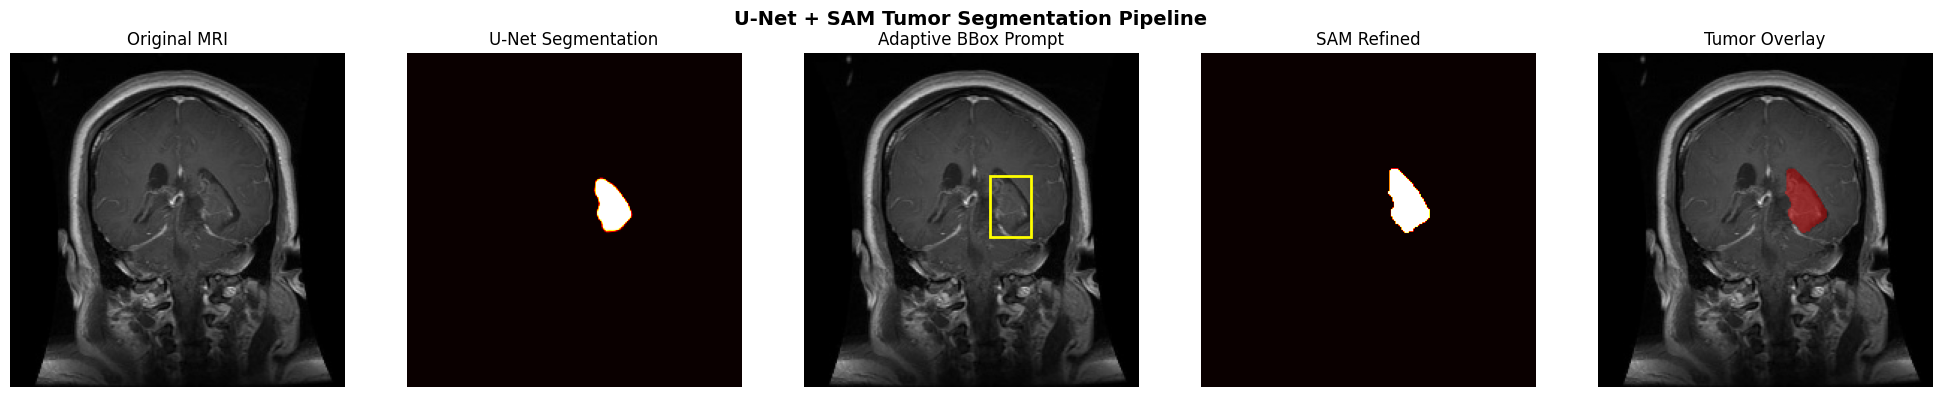

Bounding box: [124, 82, 152, 123]
U-Net tumor area: 575 pixels
SAM tumor area: 737 pixels

Processing batch...
Processing image 1/3


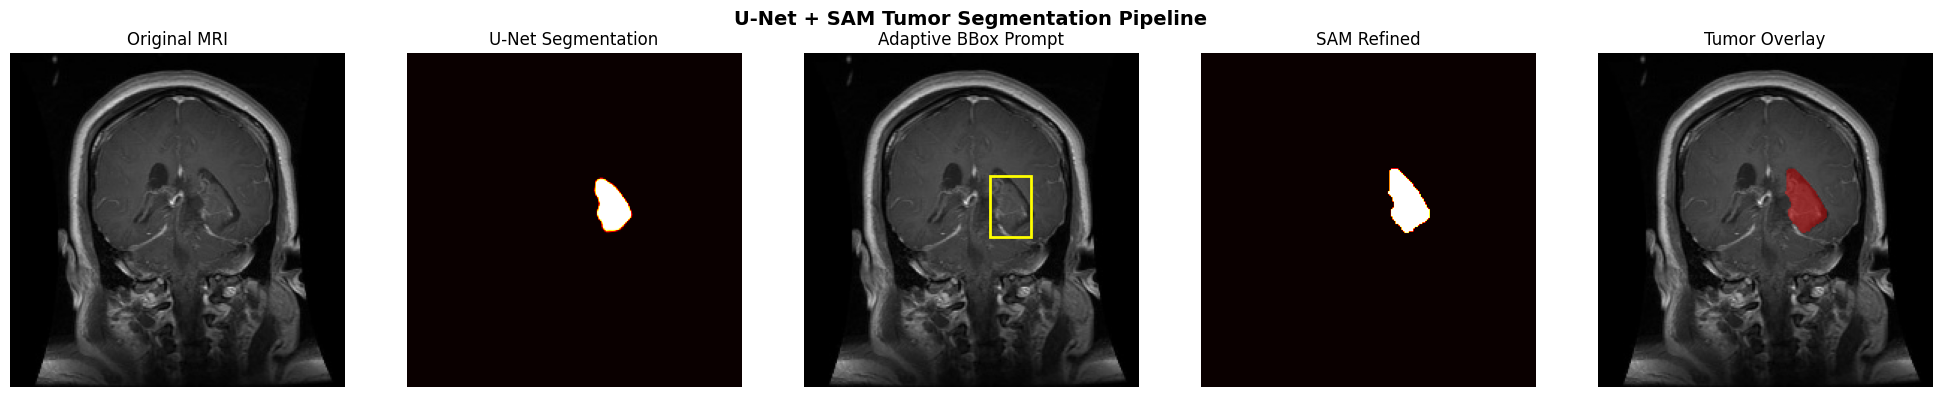

Processing image 2/3


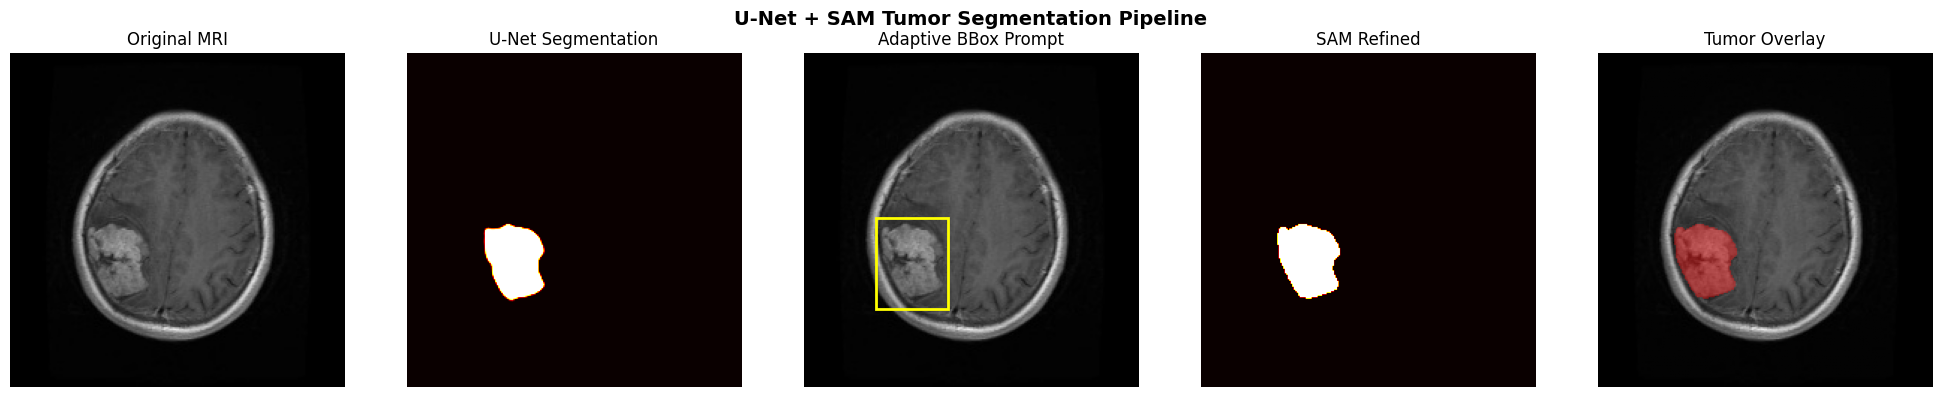

Processing image 3/3


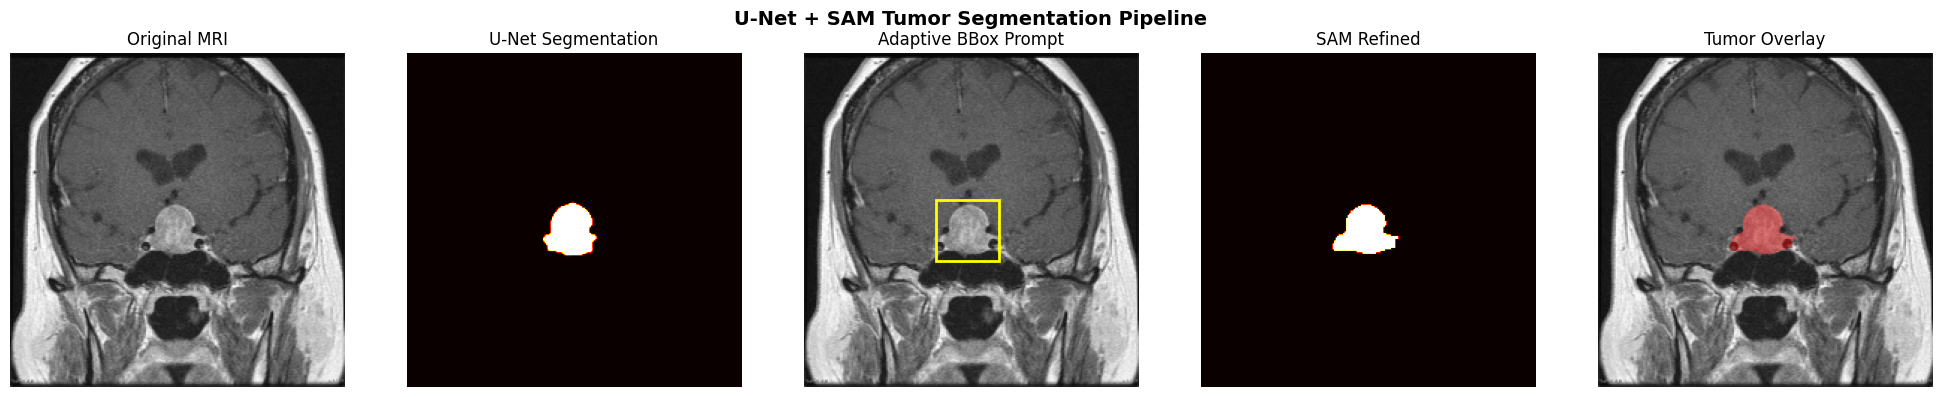

In [38]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import wget
import os
import gc

class UNetSAMInference:
    """Optimized inference pipeline for U-Net + SAM"""
    
    def __init__(self, unet_checkpoint_path, sam_checkpoint_path=None, device='cuda'):
        self.device = device
        
        # Load U-Net
        print("Loading U-Net model...")
        self.unet = ResNetUNet().to(device)
        checkpoint = torch.load(unet_checkpoint_path, map_location=device)
        self.unet.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
        self.unet.eval()
        del checkpoint
        torch.cuda.empty_cache()
        
        # Download SAM if needed
        if sam_checkpoint_path is None:
            sam_checkpoint_path = '/kaggle/working/sam_vit_h_4b8939.pth'
            if not os.path.exists(sam_checkpoint_path):
                print("Downloading SAM...")
                wget.download('https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth', 
                            sam_checkpoint_path)
        
        # Load SAM
        print("Loading SAM model...")
        sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint_path)
        sam.to(device)
        self.sam_predictor = SamPredictor(sam)
        torch.cuda.empty_cache()
        
        # Image preprocessing
        self.normalize_mean = [0.485, 0.456, 0.406]
        self.normalize_std = [0.229, 0.224, 0.225]
        
        print("Models loaded successfully!")
    
    def preprocess_image(self, image_path):
        """Load and preprocess image for U-Net"""
        # Load image
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = np.array(image_path)
            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # Store original for SAM
        self.original_image = image.copy()
        
        # Resize to 224x224 for U-Net
        image_resized = cv2.resize(image, (224, 224))
        
        # Normalize
        image_norm = image_resized.astype(np.float32) / 255.0
        for i in range(3):
            image_norm[:, :, i] = (image_norm[:, :, i] - self.normalize_mean[i]) / self.normalize_std[i]
        
        # Convert to tensor
        image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).unsqueeze(0).float()
        
        return image_tensor, image_resized
    
    def mask_to_adaptive_bbox(self, mask, threshold=0.5):
        """
        Convert mask to adaptive bounding box
        - 2x size for small areas (<100 pixels)
        - Minimum covering box otherwise
        """
        binary_mask = (mask > threshold).astype(np.uint8)
        
        if binary_mask.sum() == 0:
            return None
        
        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return None
        
        # Get largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Adaptive sizing
        area = w * h
        if area < 100:  # Small tumor - expand bbox by 2x
            center_x, center_y = x + w//2, y + h//2
            new_w, new_h = w * 2, h * 2
            x = max(0, center_x - new_w//2)
            y = max(0, center_y - new_h//2)
            w = min(new_w, mask.shape[1] - x)
            h = min(new_h, mask.shape[0] - y)
        else:
            # Add small padding (10% of dimensions)
            padding_x = int(w * 0.1)
            padding_y = int(h * 0.1)
            x = max(0, x - padding_x)
            y = max(0, y - padding_y)
            w = min(w + 2*padding_x, mask.shape[1] - x)
            h = min(h + 2*padding_y, mask.shape[0] - y)
        
        return [x, y, x + w, y + h]
    
    @torch.no_grad()
    def predict_single_image(self, image_path):
        """
        Complete inference pipeline for a single image
        Returns: unet_mask, sam_mask, bbox
        """
        # Clear GPU memory
        torch.cuda.empty_cache()
        
        # Preprocess image
        image_tensor, image_resized = self.preprocess_image(image_path)
        image_tensor = image_tensor.to(self.device)
        
        # U-Net prediction
        with torch.cuda.amp.autocast():
            unet_output = self.unet(image_tensor)
        
        unet_mask = torch.sigmoid(unet_output).squeeze().cpu().numpy()
        
        # Clear U-Net memory
        del unet_output, image_tensor
        torch.cuda.empty_cache()
        
        # Get adaptive bounding box
        bbox = self.mask_to_adaptive_bbox(unet_mask, threshold=0.5)
        
        if bbox is None:
            print("No tumor detected by U-Net")
            return unet_mask, unet_mask, None
        
        # Prepare image for SAM (use original resolution)
        sam_image = cv2.resize(self.original_image, (224, 224))
        
        # SAM refinement with bbox prompt
        self.sam_predictor.set_image(sam_image)
        masks, scores, _ = self.sam_predictor.predict(
            box=np.array(bbox),
            multimask_output=False
        )
        
        sam_mask = masks[0].astype(np.float32)
        
        # Clear SAM memory
        torch.cuda.empty_cache()
        
        return unet_mask, sam_mask, bbox
    
    def visualize_results(self, image_path, save_path=None):
        """
        Visualize original image, U-Net mask, SAM mask, and overlay
        """
        # Get predictions
        unet_mask, sam_mask, bbox = self.predict_single_image(image_path)
        
        # Load original image for display
        if isinstance(image_path, str):
            original = cv2.imread(image_path)
            original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        else:
            original = np.array(image_path)
        
        # Resize for consistent display
        original_resized = cv2.resize(original, (224, 224))
        
        # Create figure
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        
        # 1. Original image
        axes[0].imshow(original_resized)
        axes[0].set_title('Original MRI')
        axes[0].axis('off')
        
        # 2. U-Net mask
        axes[1].imshow(unet_mask, cmap='hot', vmin=0, vmax=1)
        axes[1].set_title('U-Net Segmentation')
        axes[1].axis('off')
        
        # 3. U-Net with BBox
        axes[2].imshow(original_resized)
        if bbox:
            rect = plt.Rectangle((bbox[0], bbox[1]), 
                                bbox[2]-bbox[0], bbox[3]-bbox[1],
                                fill=False, color='yellow', linewidth=2)
            axes[2].add_patch(rect)
        axes[2].set_title('Adaptive BBox Prompt')
        axes[2].axis('off')
        
        # 4. SAM refined mask
        axes[3].imshow(sam_mask, cmap='hot', vmin=0, vmax=1)
        axes[3].set_title('SAM Refined')
        axes[3].axis('off')
        
        # 5. Overlay on original
        overlay = self.create_overlay(original_resized, sam_mask)
        axes[4].imshow(overlay)
        axes[4].set_title('Tumor Overlay')
        axes[4].axis('off')
        
        plt.suptitle('U-Net + SAM Tumor Segmentation Pipeline', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        # Clean up
        plt.close()
        gc.collect()
        
        return unet_mask, sam_mask, bbox
    
    def create_overlay(self, image, mask, color=[1, 0, 0], alpha=0.4):
        """Create overlay visualization"""
        overlay = image.copy()
        if overlay.max() > 1:
            overlay = overlay / 255.0
        
        binary_mask = (mask > 0.5)
        
        for c in range(3):
            overlay[:, :, c] = np.where(binary_mask,
                                       overlay[:, :, c] * (1-alpha) + color[c] * alpha,
                                       overlay[:, :, c])
        
        return overlay
    
    def process_batch(self, image_paths, visualize=False):
        """Process multiple images efficiently"""
        results = []
        
        for idx, img_path in enumerate(image_paths):
            print(f"Processing image {idx+1}/{len(image_paths)}")
            
            if visualize:
                unet_mask, sam_mask, bbox = self.visualize_results(img_path)
            else:
                unet_mask, sam_mask, bbox = self.predict_single_image(img_path)
            
            results.append({
                'image_path': img_path,
                'unet_mask': unet_mask,
                'sam_mask': sam_mask,
                'bbox': bbox
            })
            
            # Clear memory every 5 images
            if (idx + 1) % 5 == 0:
                torch.cuda.empty_cache()
                gc.collect()
        
        return results

# Usage Example
def main_inference():
    """Example usage of the inference pipeline"""
    
    # Initialize pipeline
    unet_path = '/kaggle/working/unet_outputs/checkpoints/best_iou_model.pth'
    pipeline = UNetSAMInference(unet_path)
    
    # Test on single image
    test_image = '/kaggle/working/sam_baseline_img_test_dataset/test/Glioma/Tr-gl_0028_jpg.rf.8098b9737048aac0dccb1b7c45046894_annotated.jpg'
    
    # Visualize results
    print("\nProcessing single image with visualization...")
    unet_mask, sam_mask, bbox = pipeline.visualize_results(
        test_image, 
        save_path='/kaggle/working/inference_result.png'
    )
    
    # Print statistics
    if bbox:
        print(f"Bounding box: {bbox}")
        print(f"U-Net tumor area: {(unet_mask > 0.5).sum()} pixels")
        print(f"SAM tumor area: {(sam_mask > 0.5).sum()} pixels")
    
    # Process multiple images
    test_images = [
        '/kaggle/working/sam_baseline_img_test_dataset/test/Glioma/Tr-gl_0028_jpg.rf.8098b9737048aac0dccb1b7c45046894_annotated.jpg',
        '/kaggle/working/sam_baseline_img_test_dataset/test/Meningioma/Tr-me_0010_jpg.rf.64b09cdfd6ad5f8352e473a7d3015dba_annotated.jpg',
        '/kaggle/working/sam_baseline_img_test_dataset/test/Pituitary/Tr-pi_0038_jpg.rf.50c4875c32834d727e1b02ce11ca571b_annotated.jpg'
    ]
    
    print("\nProcessing batch...")
    results = pipeline.process_batch(test_images, visualize=True)
    
    # Clean up
    del pipeline
    torch.cuda.empty_cache()
    gc.collect()

# Run inference
if __name__ == "__main__":
    main_inference()